In [1]:
import sys, os
os.path.dirname(sys.executable)

'/clusterfs/nilah/sergio/miniconda3/envs/ESM_cambrian/bin'

In [2]:
sys.path.append('/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/')
from ESMCBA.imports import * 
from ESMCBA import other_utils

In [3]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [4]:
# pd.read_csv('/global/scratch/users/sergiomar10/benchmark/RFD_BENCHMARK/A0201all_binders_mhc_flurry.csv')
# mhcflurry = pd.read_csv('/global/scratch/users/sergiomar10/benchmark/RFD_BENCHMARK/A0201all_binders_mhc_flurry.csv')
# mhcflurry['mhc_log'] = mhcflurry['mhcflurry_affinity'].apply(np.log10)
# _ = pd.read_csv('/global/scratch/users/sergiomar10/benchmark/RFD_BENCHMARK/A0201_epitope-A0201_umap.csv')
# sns.set(style="white")
# sns.scatterplot(data=_, x="UMAP_1", y="UMAP_2")
# plt.show()

# Get list of all UMAP files
umap_files = glob.glob('/global/scratch/users/sergiomar10/benchmark/RFD_BENCHMARK/A0201*epitope*_umap.csv')
umap_files

['/global/scratch/users/sergiomar10/benchmark/RFD_BENCHMARK/A0201_epitope-A0201_umap.csv']

In [5]:
# Load the shared peptide datasets
rfd_peptides_all = pd.read_csv('/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/jupyter_notebooks/rdfiffusion/rdfiffusion_output_peptides.csv')
peptides_eval_set_ESMCBA = pd.read_csv('/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/performances/predictions_of_models.csv')

# Get list of all UMAP files
umap_files = glob.glob('/global/scratch/users/sergiomar10/benchmark/RFD_BENCHMARK/A0201*epitope*_umap.csv')

# Create empty list to collect the merged DataFrames
all_predictions = []

pretty_names = {
    'measured': 'Experimental IC₅₀ Measurement',
    'mhc_log_y': 'MHCflurry log₁₀ IC₅₀ Prediction',
    'BA_Rank': 'NetMHCpan Rank',
    'prediction_x': 'ESMCBA log₁₀ IC₅₀ Prediction',
    'plddt': 'AF2 pLDDT',
    'mpnn': 'ProteinMPNN Score',
    'rmsd': 'AF2 RMSD',
    'i_pae': 'AF2 Interface PAE',
    'i_ptm': 'AF2 iPTM Score',
    'PERMUTATION_TEST' : 'Anchor-Preserved Mutagenesis Baseline',
    'RANDOM_SAMPLED' : 'Global Sequence Sampling Control'
}

sns.set_style("white")

# Now loop over each file
for file in umap_files:
    filename = os.path.basename(file)
    hla = filename.split('_')[0]  # e.g., 'B1501' from 'B1501_epitope-B1501_umap.csv'


    if 'epitope' not in filename:
        continue

    if 'A0201' not in filename:
        continue

    # Load UMAP predictions
    ESCMBA_predictions = pd.read_csv(file)


    mhcflurry = pd.read_csv(f'/global/scratch/users/sergiomar10/benchmark/RFD_BENCHMARK/{hla}FINAL_RS_RFD_MAC__mhc_flurry.csv')
    mhcflurry['mhc_log'] = mhcflurry['mhcflurry_affinity'].apply(np.log10)

    # try:
    netmhcspan = pd.read_csv(f'/global/scratch/users/sergiomar10/benchmark/RFD_BENCHMARK/FINAL_RS_RFD_MAC__{hla}_netmhc.xls', sep = '\t', header = 1)
    # exscept:

    # if mhc_log.empty:   
    #     print(f"Warning: No mhc_log data for {hla}. Skipping this file.")
    #     continue

    # Subset RFD peptides for this HLA
    rfd_peptides = rfd_peptides_all[rfd_peptides_all['hla_allele'] == hla]

    # Skip if no peptides
    if len(rfd_peptides) == 0:
        continue

    # Subset evaluation set
    peptides_eval = peptides_eval_set_ESMCBA[peptides_eval_set_ESMCBA['Model'] == f'{hla} epitope']

    # Merge data
    ESCMBA_predictions = pd.merge(ESCMBA_predictions, peptides_eval, on='sequence', how='left')
    ESCMBA_predictions = pd.merge(ESCMBA_predictions, rfd_peptides, left_on='sequence', right_on='epitope', how='left')
    ESCMBA_predictions = pd.merge(ESCMBA_predictions, mhcflurry[['peptide','mhc_log','mhcflurry_presentation_score']], left_on='sequence', right_on='peptide', how='left')
    ESCMBA_predictions = pd.merge(ESCMBA_predictions, netmhcspan[['Peptide','BA_Rank']], left_on='sequence', right_on='Peptide', how='left')    

    # Add a column for HLA for traceability
    ESCMBA_predictions['HLA'] = hla

    random_sampled = pd.read_csv('9mers_esm2.csv')
    # random_sampled['RANDOM_SAMPLED'] = True

    ESCMBA_predictions = pd.merge(left=ESCMBA_predictions, right=random_sampled, on='sequence', how='left')

    ESCMBA_predictions['RANDOM_SAMPLED'] = ESCMBA_predictions['sequence'].isin(random_sampled['sequence'])

    ESCMBA_predictions['PERMUTATION_TEST'] = (
    (ESCMBA_predictions['RANDOM_SAMPLED'] == False ) & (ESCMBA_predictions['plddt'].isna())
)

    # Append this merged df to list
    all_predictions.append(ESCMBA_predictions)

    # ---- (your plotting code stays exactly the same) ----
    hue_columns = [
        'measured', 'PERMUTATION_TEST', 'RANDOM_SAMPLED', 'mhc_log_y', 'BA_Rank',
        'prediction_x', 'plddt', 'mpnn', 'i_ptm'
    ]

    n_cols = 3
    n_rows = (len(hue_columns) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 7 * n_rows))
    axes = axes.flatten()

import matplotlib as mpl
from matplotlib.colors import ListedColormap

# define discrete colormaps
perm_cmap   = ListedColormap(['lightgray', 'tab:orange'])
random_cmap = ListedColormap(['lightgray', 'tab:blue'])

for idx, hue_var in enumerate(hue_columns):
    ax = axes[idx]
    subset = ESCMBA_predictions[ESCMBA_predictions[hue_var].notna()]

    # choose cmap and norm
    if hue_var == 'PERMUTATION_TEST':
        cmap = perm_cmap
        norm = mpl.colors.BoundaryNorm([0, 0.5, 1], perm_cmap.N)
    elif hue_var == 'RANDOM_SAMPLED':
        cmap = random_cmap
        norm = mpl.colors.BoundaryNorm([0, 0.5, 1], random_cmap.N)
    else:
        cmap = 'viridis'
        norm = None

    points = ax.scatter(
        subset['UMAP_1'],
        subset['UMAP_2'],
        c=subset[hue_var],
        cmap=cmap,
        norm=norm,
        s=5,
        edgecolor=None
    )

    title_str = pretty_names.get(hue_var, hue_var)
    ax.set_title(title_str, fontsize=14)
    ax.set_xlabel('UMAP 1', fontsize=12)
    ax.set_ylabel('UMAP 2', fontsize=12)
    ax.set_xlim(subset['UMAP_1'].min(), subset['UMAP_1'].max())
    ax.set_ylim(subset['UMAP_2'].min(), subset['UMAP_2'].max())

    ax.set_xlim(-2, 12)
    ax.set_ylim(0, 13)

    cbar = fig.colorbar(
        points,
        ax=ax,
        orientation='vertical',
        pad=0.01,
        aspect=30
    )
    cbar.set_label(title_str, fontsize=10)

    # if discrete baseline, show True/False ticks
    if hue_var in ('PERMUTATION_TEST', 'RANDOM_SAMPLED'):
        cbar.set_ticks([0.25, 0.75])
        cbar.set_ticklabels(['False', 'True'])

    # plt.tight_layout()
    # plt.suptitle(f'UMAP analysis for {filename}', fontsize=16, y=1.02)

    # # save figures as PDF
output_dir = '/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/figures/'
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, f'{hla}_2UMAP_analysis.pdf')
plt.savefig(output_path, bbox_inches='tight')
plt.show()
# # plt.tight_layout()
# plt.show()


# ====> AFTER the loop finishes:
# Concatenate all merged DataFrames together
final_df = pd.concat(all_predictions, ignore_index=True)

# # Save it to CSV (or pickle, up to you)
# final_df.to_csv('/global/scratch/users/sergiomar10/benchmark/RFD_BENCHMARK/ALL_MERGED_UMAP_predictions.csv', index=False)

# print(f"✅ Saved merged UMAP dataframe with shape {final_df.shape}")

FileNotFoundError: [Errno 2] No such file or directory: '/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/jupyter_notebooks/rdfiffusion/rdfiffusion_output_peptides.csv'

In [ ]:
ESCMBA_predictions['length_x'] = ESCMBA_predictions['sequence'].apply(len)

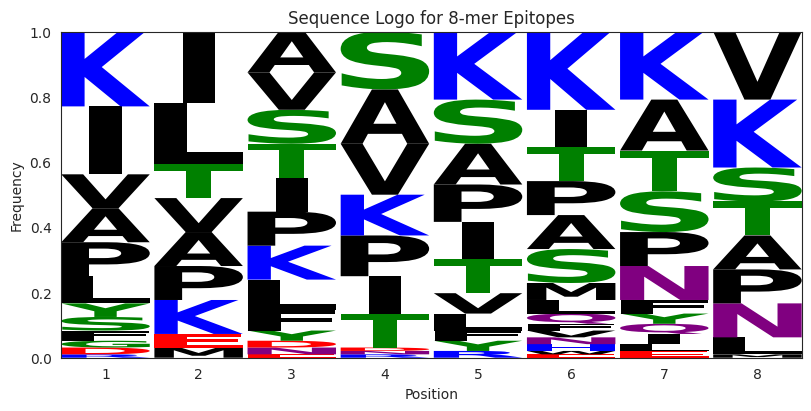

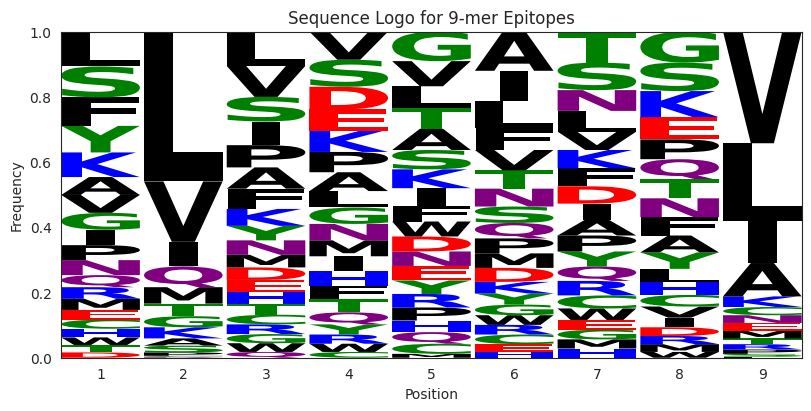

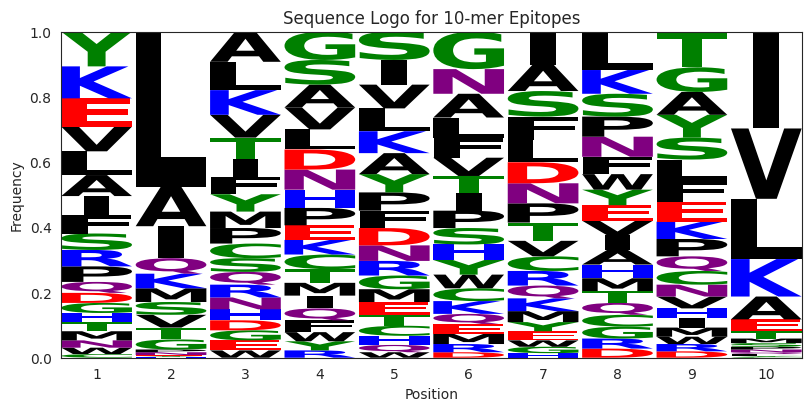

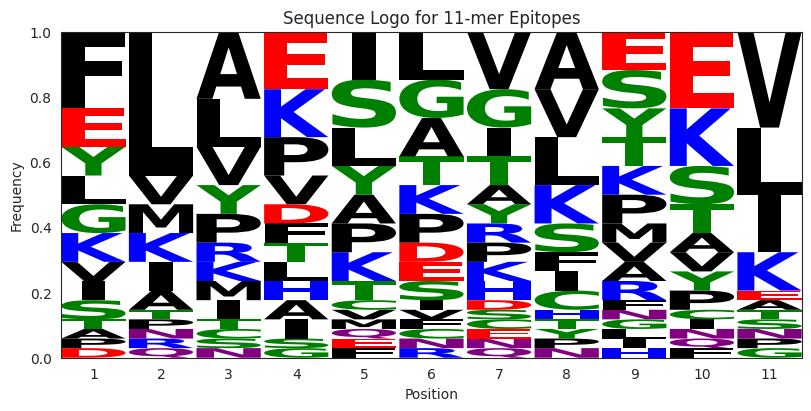

No sequences found for length 12
No sequences found for length 13
No sequences found for length 14


In [ ]:
import logomaker
import os

# Define standard amino acids
amino_acids = list("ACDEFGHIKLMNPQRSTVWY")

# Output directory for saving figures
output_dir = '/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/figures/'
os.makedirs(output_dir, exist_ok=True)

# Loop through epitope lengths
for n in range(8, 15):
    # Filter sequences from ESCMBA_predictions
    sequences = ESCMBA_predictions[
        # (ESCMBA_predictions['plddt'] >= 0.8) &  # High-confidence predictions
        (ESCMBA_predictions['PERMUTATION_TEST'] == True) &  # Not permutati
        (ESCMBA_predictions['length_x'] == n)  # Length of interest

    ]['sequence'].to_list()

    # print(sequences)
    # Only proceed if sequences are found
    if sequences:
        # Initialize frequency matrix
        freq_matrix = np.zeros((n, len(amino_acids)))

        # Compute frequency for each position and amino acid
        for seq in sequences:
            if len(seq) == n:  # Ensure sequence length matches
                for j, aa in enumerate(seq):
                    if aa in amino_acids:
                        freq_matrix[j, amino_acids.index(aa)] += 1

        # Normalize by number of sequences
        if len(sequences) > 0:
            freq_matrix /= len([seq for seq in sequences if len(seq) == n])

        # Create DataFrame for logomaker
        freq_df = pd.DataFrame(freq_matrix, columns=amino_acids)

        # Create figure and axis
        fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)

        # Generate sequence logo
        logomaker.Logo(freq_df, ax=ax, color_scheme='chemistry')
        ax.set_xlabel("Position")
        ax.set_ylabel("Frequency")
        ax.set_xticks(range(n))
        ax.set_xticklabels(range(1, n + 1))
        ax.set_title(f"Sequence Logo for {n}-mer Epitopes")

        # Save figure
        output_path = os.path.join(output_dir, f'seqlogo_{n}_random_peptides_mer.pdf')
        plt.savefig(output_path, bbox_inches='tight')
        plt.show()
    else:
        print(f"No sequences found for length {n}")

    # Close figure to free memory
    plt.close(fig)

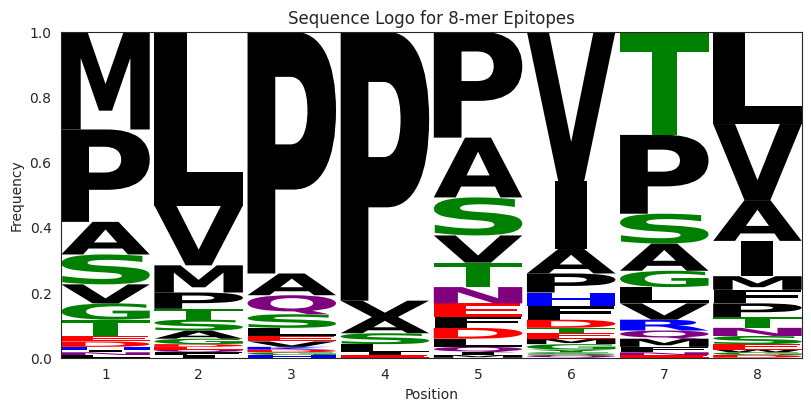

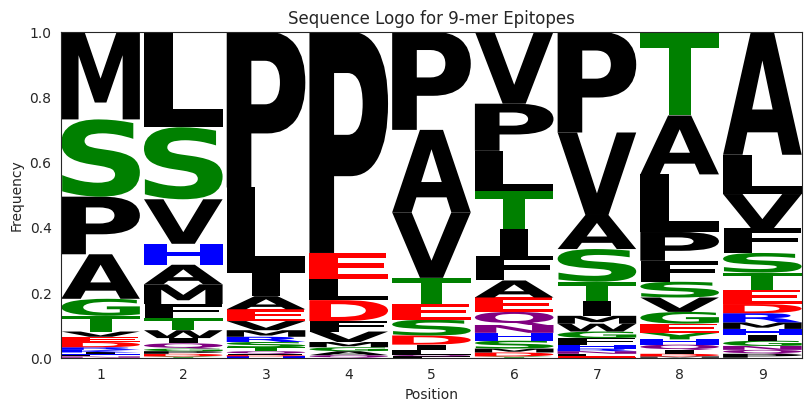

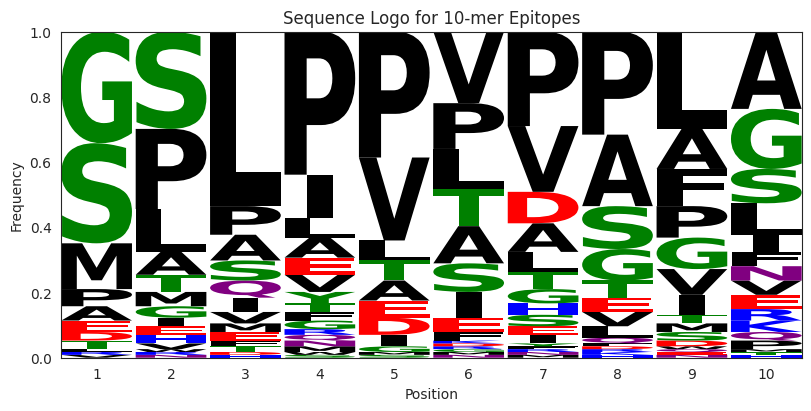

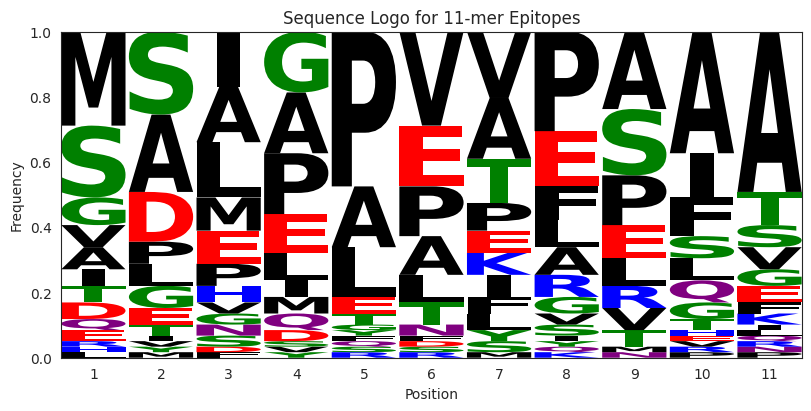

No sequences found for length 12
No sequences found for length 13
No sequences found for length 14


In [ ]:
import logomaker
import os

# Define standard amino acids
amino_acids = list("ACDEFGHIKLMNPQRSTVWY")

# Output directory for saving figures
output_dir = '/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/figures/'
os.makedirs(output_dir, exist_ok=True)

# Loop through epitope lengths
for n in range(8, 15):
    # Filter sequences from ESCMBA_predictions
    sequences = ESCMBA_predictions[
        (ESCMBA_predictions['plddt'] >= 0.8) &  # High-confidence predictions
        # (ESCMBA_predictions['PERMUTATION_TEST'] == True) &  # Not permutati
        (ESCMBA_predictions['length_x'] == n)  # Length of interest

    ]['sequence'].to_list()

    # print(sequences)
    # Only proceed if sequences are found
    if sequences:
        # Initialize frequency matrix
        freq_matrix = np.zeros((n, len(amino_acids)))

        # Compute frequency for each position and amino acid
        for seq in sequences:
            if len(seq) == n:  # Ensure sequence length matches
                for j, aa in enumerate(seq):
                    if aa in amino_acids:
                        freq_matrix[j, amino_acids.index(aa)] += 1

        # Normalize by number of sequences
        if len(sequences) > 0:
            freq_matrix /= len([seq for seq in sequences if len(seq) == n])

        # Create DataFrame for logomaker
        freq_df = pd.DataFrame(freq_matrix, columns=amino_acids)

        # Create figure and axis
        fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)

        # Generate sequence logo
        logomaker.Logo(freq_df, ax=ax, color_scheme='chemistry')
        ax.set_xlabel("Position")
        ax.set_ylabel("Frequency")
        ax.set_xticks(range(n))
        ax.set_xticklabels(range(1, n + 1))
        ax.set_title(f"Sequence Logo for {n}-mer Epitopes")

        # Save figure
        output_path = os.path.join(output_dir, f'seqlogo_{n}_random_peptides_mer.pdf')
        plt.savefig(output_path, bbox_inches='tight')
        plt.show()
    else:
        print(f"No sequences found for length {n}")

    # Close figure to free memory
    plt.close(fig)

In [ ]:
# pick and rename only the columns we actually use
keep = {
    'sequence':             'sequence',
    'HLA':                  'HLA',
    'plddt':                'AF2_pLDDT',
    'mpnn':                 'ProteinMPNN',
    'i_ptm':                'AF2_iPTM',
    'mhc_log_y':            'MHCflurry_logIC50',
    'BA_Rank':              'NetMHCpan_rank',
    'prediction_x':         'ESMCBA_logIC50',
    'measured':             'Experimental_IC50',
    'PERMUTATION_TEST':     'Anchor_Mutagenesis',
    'RANDOM_SAMPLED':       'LM_Sampled'
}
df = ESCMBA_predictions[list(keep)].rename(columns=keep)


In [ ]:
hla_athena = pd.read_csv('/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/jupyter_notebooks/rdfiffusion/predictions_20250501.211412.tsv', sep='\t')
hla_athena = hla_athena[['pep','MSi_A0201']]

hla_athena2 = pd.read_csv('/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/jupyter_notebooks/rdfiffusion/predictions_20250501.213202.tsv', sep='\t')
hla_athena2 = hla_athena2[['pep','MSi_A0201']]

hla_athena = pd.concat([hla_athena, hla_athena2], ignore_index=True)

hla_athena2 = pd.read_csv('/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/jupyter_notebooks/rdfiffusion/predictions_20250501.214047.tsv', sep='\t')
hla_athena2 = hla_athena2[['pep','MSi_A0201']]

hla_athena = pd.concat([hla_athena, hla_athena2], ignore_index=True)
hla_athena.head()


df = ESCMBA_predictions
df = pd.merge(df, hla_athena, left_on='sequence', right_on='pep', how='left').drop(columns=['pep']).rename(columns={'MSi_A0201': 'Athena_MSI'})


In [ ]:
HLAPOLLO = pd.read_csv('/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/jupyter_notebooks/rdfiffusion/RFDIFFUSION_HLAPOLLO.csv')
HLAPOLLO.head()

hla_athena = pd.read_csv('/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/jupyter_notebooks/rdfiffusion/predictions_20250501.211412.tsv', sep='\t')
hla_athena = hla_athena[['pep','MSi_A0201']]

hla_athena2 = pd.read_csv('/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/jupyter_notebooks/rdfiffusion/predictions_20250501.213202.tsv', sep='\t')
hla_athena2 = hla_athena2[['pep','MSi_A0201']]

hla_athena = pd.concat([hla_athena, hla_athena2], ignore_index=True)

hla_athena2 = pd.read_csv('/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/jupyter_notebooks/rdfiffusion/predictions_20250501.214047.tsv', sep='\t')
hla_athena2 = hla_athena2[['pep','MSi_A0201']]

hla_athena = pd.concat([hla_athena, hla_athena2], ignore_index=True)
hla_athena.head()

pep  MSi_A0201
0  LLFSLLAV   0.994214
1  LLFSLLAV   0.994214
2  LLFSLLAV   0.994214
3  LLFSLLAV   0.994214
4  YIVILWAV   0.810533

In [ ]:
dt = pd.merge(ESCMBA_predictions, HLAPOLLO[['peptide','mhc_pred_0']], left_on='sequence', right_on='peptide', how='left').drop(columns=['peptide']) #.rename(columns={'MSi_A0201': 'Athena_MSI'})
dt = pd.merge(dt, hla_athena, left_on='sequence', right_on='pep', how='left').drop(columns=['pep']).rename(columns={'MSi_A0201': 'Athena_MSI'})


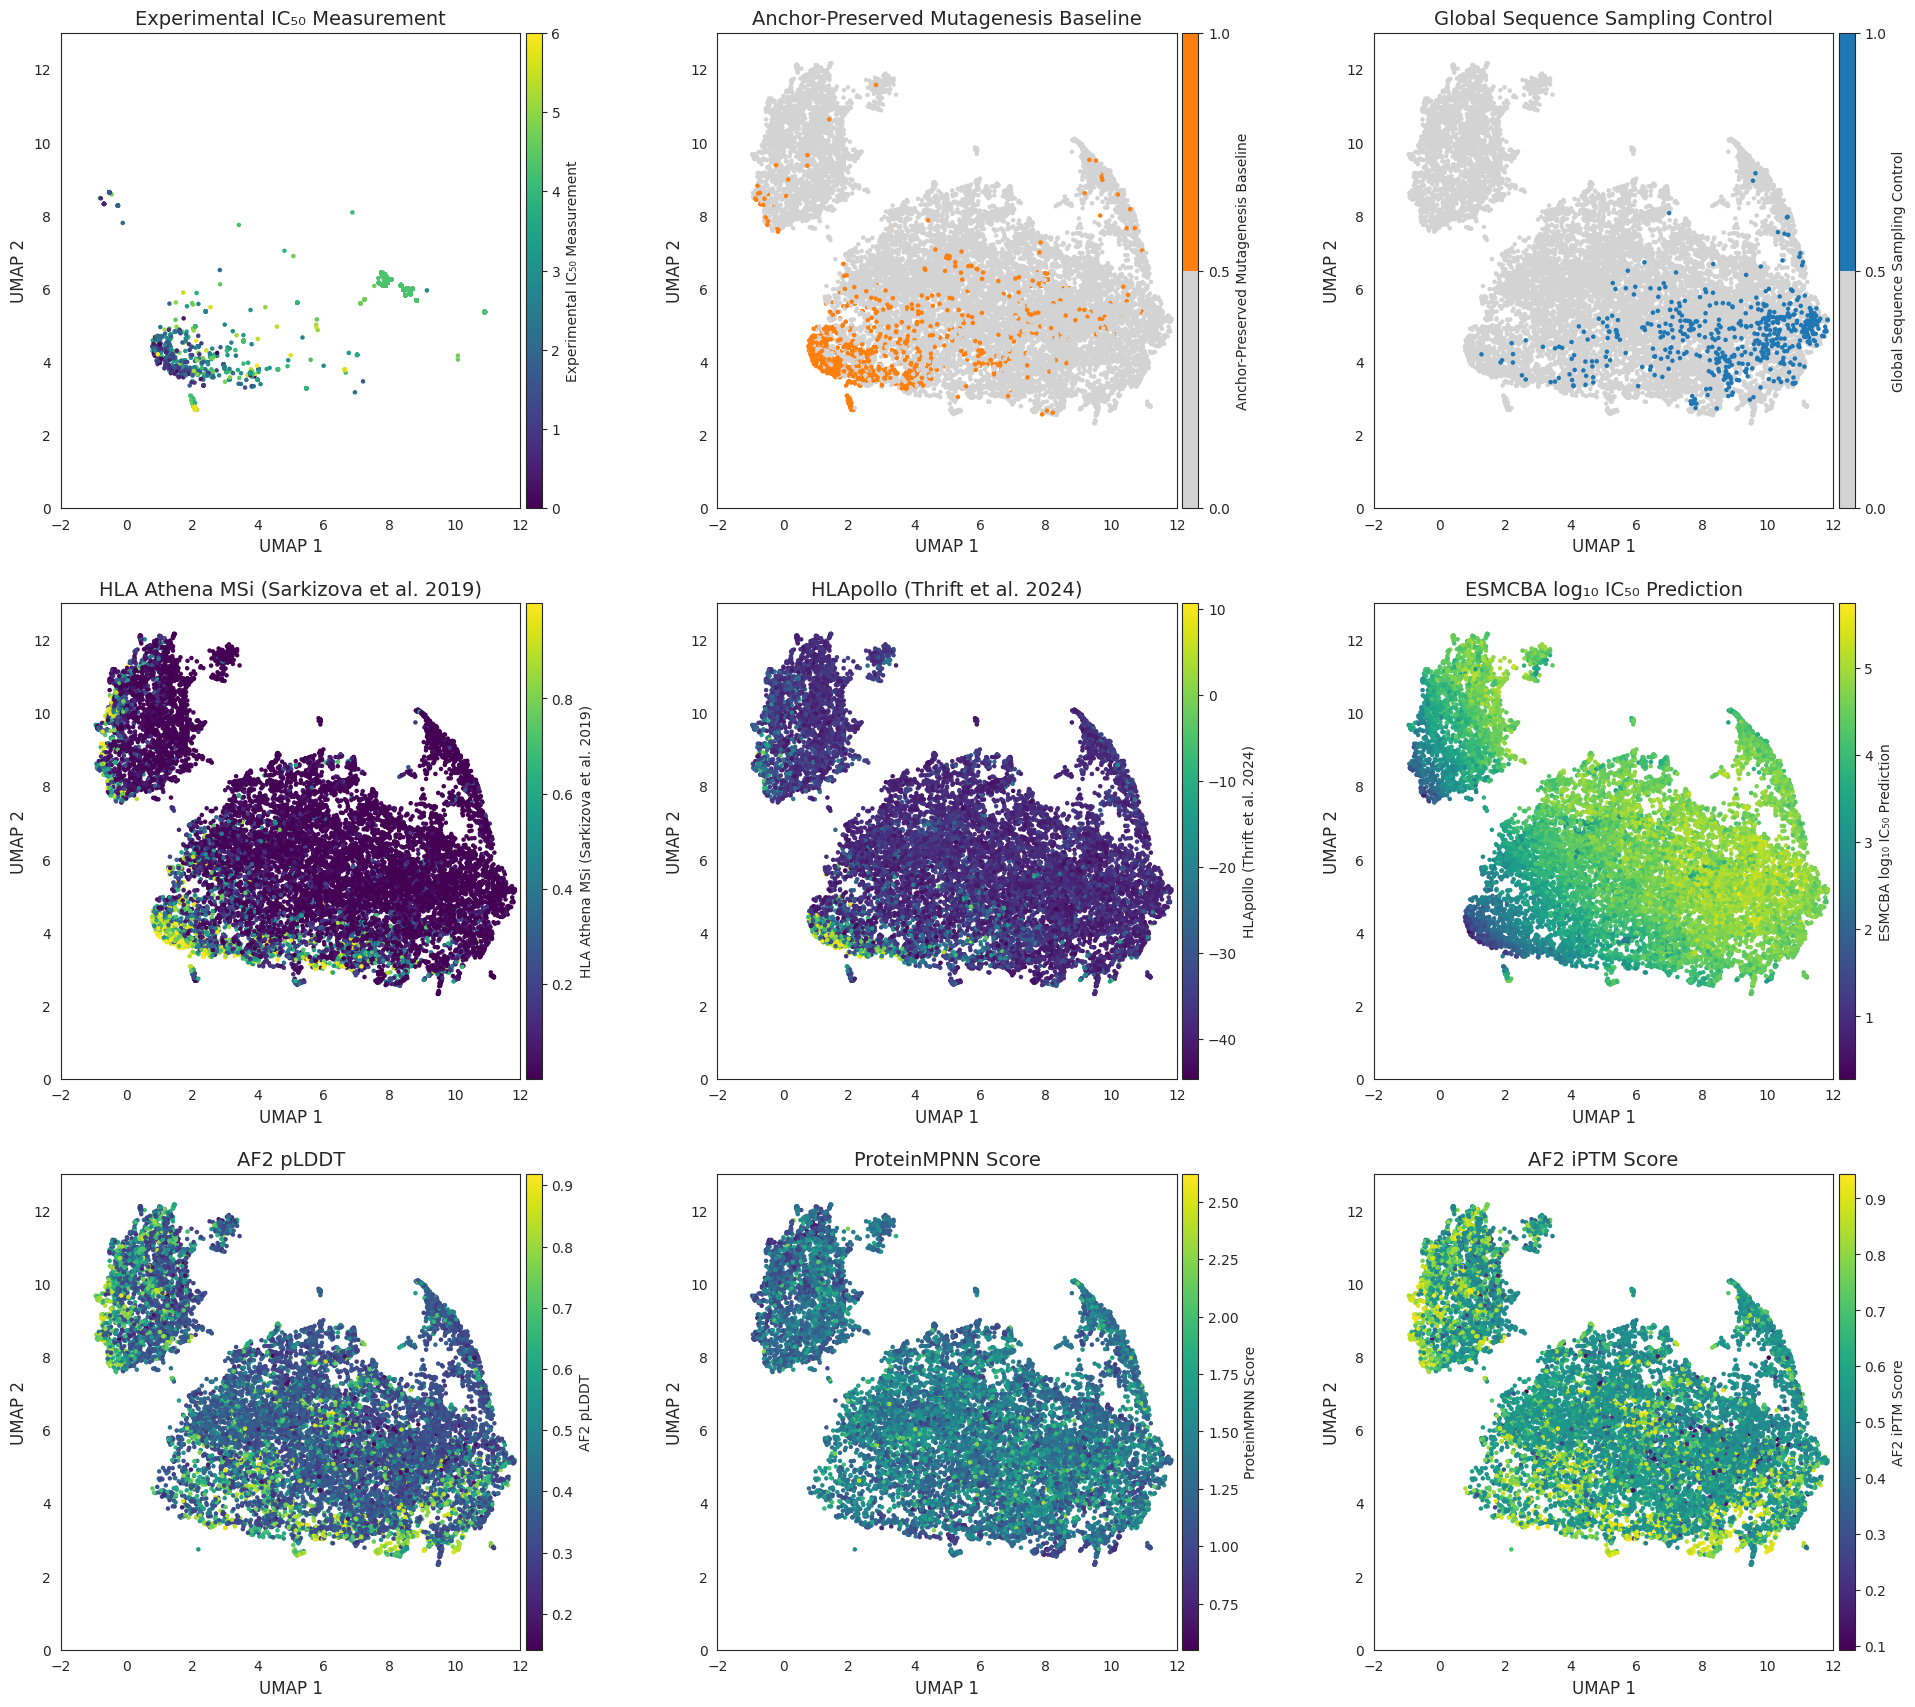

In [ ]:
pretty_names = {
    'measured': 'Experimental IC₅₀ Measurement',
    'mhc_log_y': 'MHCflurry log₁₀ IC₅₀ Prediction',
    'BA_Rank': 'NetMHCpan Rank',
    'prediction_x': 'ESMCBA log₁₀ IC₅₀ Prediction',
    'plddt': 'AF2 pLDDT',
    'mpnn': 'ProteinMPNN Score',
    'rmsd': 'AF2 RMSD',
    'i_pae': 'AF2 Interface PAE',
    'i_ptm': 'AF2 iPTM Score',
    'PERMUTATION_TEST' : 'Anchor-Preserved Mutagenesis Baseline',
    'RANDOM_SAMPLED' : 'Global Sequence Sampling Control',
    'Athena_MSI': 'HLA Athena MSi (Sarkizova et al. 2019)',
    'mhc_pred_0': 'HLApollo (Thrift et al. 2024)'
}

# ---- (your plotting code stays exactly the same) ----
hue_columns = [
    'measured', 'PERMUTATION_TEST', 'RANDOM_SAMPLED', 'Athena_MSI', 'mhc_pred_0',
    'prediction_x', 'plddt', 'mpnn', 'i_ptm'
]


n_cols = 3
n_rows = (len(hue_columns) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 7 * n_rows))
axes = axes.flatten()

# define discrete colormaps
perm_cmap   = ListedColormap(['lightgray', 'tab:orange'])
random_cmap = ListedColormap(['lightgray', 'tab:blue'])

for idx, hue_var in enumerate(hue_columns):
    ax = axes[idx]
    subset = dt[dt[hue_var].notna()]

    # choose cmap and norm
    if hue_var == 'PERMUTATION_TEST':
        cmap = perm_cmap
        norm = mpl.colors.BoundaryNorm([0, 0.5, 1], perm_cmap.N)
    elif hue_var == 'RANDOM_SAMPLED':
        cmap = random_cmap
        norm = mpl.colors.BoundaryNorm([0, 0.5, 1], random_cmap.N)
    else:
        cmap = 'viridis'
        norm = None

    points = ax.scatter(
        subset['UMAP_1'],
        subset['UMAP_2'],
        c=subset[hue_var],
        cmap=cmap,
        norm=norm,
        s=5,
        edgecolor=None
    )

    title_str = pretty_names.get(hue_var, hue_var)
    ax.set_title(title_str, fontsize=14)
    ax.set_xlabel('UMAP 1', fontsize=12)
    ax.set_ylabel('UMAP 2', fontsize=12)
    ax.set_xlim(subset['UMAP_1'].min(), subset['UMAP_1'].max())
    ax.set_ylim(subset['UMAP_2'].min(), subset['UMAP_2'].max())

    ax.set_xlim(-2, 12)
    ax.set_ylim(0, 13)

    cbar = fig.colorbar(
        points,
        ax=ax,
        orientation='vertical',
        pad=0.01,
        aspect=30
    )
    cbar.set_label(title_str, fontsize=10)

# if discrete baseline, show True/False ticks
if hue_var in ('PERMUTATION_TEST', 'RANDOM_SAMPLED'):
    cbar.set_ticks([0.25, 0.75])
    cbar.set_ticklabels(['False', 'True'])

output_dir = '/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/figures/'
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, f'{hla}_3UMAP_analysis.pdf')
plt.savefig(output_path, bbox_inches='tight')
plt.show()


In [ ]:
# import matplotlib.pyplot as plt

# thresholds = np.linspace(0,1,100)  # nM
# results = {'RFdiffusion':[], 'Anchor':[], 'LM':[]}

# for thr in thresholds:
#     mask = df['Athena_MSI'] >= thr #<= np.log10(thr)
#     for name, subset in [
#         ('RFdiffusion', df_hc),
#         ('Anchor',      df_anchor),
#         ('LM',          df_lm)
#     ]:
#         rate = mask.loc[subset.index].mean() *  100
#         results[name].append(rate)

# plt.figure(figsize=(6,4))
# for name, rates in results.items():
#     plt.plot(thresholds, rates, label=name, lw=2)
# plt.xlabel('IC$_{50}$ cutoff (nM)')
# plt.ylabel('Hit rate (%)')
# plt.title('Hit‐rate vs. affinity threshold')
# plt.legend()
# plt.tight_layout()
# plt.show()


In [ ]:
# import seaborn as sns
# df_plot = pd.concat([
#     df_hc.assign(Method='RFdiffusion HC'),
#     df_anchor.assign(Method='Anchor mutagenesis'),
#     df_lm.assign(Method='LM sampling')
# ])
# sns.violinplot(data=df_plot, x='Method', y='Athena_MSI', inner='quartile',
#                palette=['tab:green','tab:orange','tab:blue'])
# plt.ylabel('Log$_{10}$ IC$_{50}$ prediction')
# plt.title('Predicted affinity distributions (pLDDT ≥ 0.8)')
# plt.tight_layout()
# plt.show()


In [ ]:
predictions = pd.read_csv('/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/jupyter_notebooks/rdfiffusion/merged_dta.csv')

/tmp/ipykernel_1214438/1387302643.py:1: DtypeWarning: Columns (62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  predictions = pd.read_csv('/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/jupyter_notebooks/rdfiffusion/merged_dta.csv')


In [ ]:
predictions

sequence  prediction  UMAP_1_x  UMAP_2_x dataset  Unnamed: 0_x  \
0      SDLSLGPEA    5.025822  5.581143  4.680666   A0201           0.0   
1      SSLSLGPEA    5.024071  5.430584  4.642436   A0201           1.0   
2      SSLSLGPHA    4.819687  5.158812  4.731397   A0201           2.0   
3      SSLSLGFHA    4.007002  4.627771  4.790965   A0201           5.0   
4      SDLSLGFEA    4.278176  5.205836  4.650356   A0201           7.0   
...          ...         ...       ...       ...     ...           ...   
24062  YVNPDAGAA    3.865093 -0.627353  7.133856   B1501          22.0   
24063  YIEPDAGAA    3.911218 -0.663394  7.097418   B1501          24.0   
24064  YIDPTAGAA    3.980139 -0.656323  7.104160   B1501          26.0   
24065  YINPDAGAG    3.283753  2.079319  4.742339   B1501          27.0   
24066  EIEPDAGAG    3.753712 -0.591897  7.124247   B1501          30.0   

       design_x   n_x    mpnn_x   plddt_x  ...  Peptide_y  BA_Rank  \
0           0.0   0.0  1.062539  0.286750  ...        NaN      NaN   
1           0.0   1.0  1.055919  0.286837  ...        NaN      NaN   
2           0.0   2.0  1.129460  0.288033  ...        NaN      NaN   
3           0.0   5.0  1.069345  0.406397  ...        NaN      NaN   
4           0.0   7.0  1.103003  0.309058  ...        NaN      NaN   
...         ...   ...       ...       ...  ...        ...      ...   
24062       0.0  22.0  1.436621  0.340256  ...  YVNPDAGAA   8.7360   
24063       0.0  24.0  1.393617  0.268060  ...  YIEPDAGAA  25.1504   
24064       0.0  26.0  1.422590  0.291395  ...  YIDPTAGAA  21.9946   
24065       0.0  27.0  1.399309  0.276736  ...  YINPDAGAG   9.8865   
24066       0.0  30.0  1.387558  0.300298  ...  EIEPDAGAG  70.6240   

       RANDOM_SAMPLED PERMUTATION_TEST plddt_x_bins  prediction_label  \
0                 NaN              NaN      0.2-0.3                 0   
1                 NaN              NaN      0.2-0.3                 0   
2                 NaN              NaN      0.2-0.3                 0   
3                 NaN              NaN      0.4-0.5                 0   
4                 NaN              NaN      0.3-0.4                 0   
...               ...              ...          ...               ...   
24062           False            False      0.3-0.4                 0   
24063           False            False      0.2-0.3                 0   
24064           False            False      0.2-0.3                 0   
24065           False            False      0.2-0.3                 0   
24066           False            False      0.3-0.4                 0   

       mhc_log_y_label  BA_Rank_label    peptide  mhc_pred_0  
0                    0              0  SDLSLGPEA  -38.507525  
1                    0              0  SSLSLGPEA  -37.665597  
2                    0              0  SSLSLGPHA  -39.210855  
3                    0              0  SSLSLGFHA  -37.809690  
4                    0              0  SDLSLGFEA  -37.442533  
...                ...            ...        ...         ...  
24062                0              1  YVNPDAGAA  -38.649507  
24063                0              1  YIEPDAGAA  -43.580001  
24064                0              1  YIDPTAGAA  -41.281255  
24065                0              1  YINPDAGAG  -42.826305  
24066                0              0  EIEPDAGAG  -42.379874  

[24067 rows x 70 columns]

In [ ]:
#### Q0 ─ Reproducible environment & global config  
# “Can the results be reproduced exactly?”

import os, random, json, numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns, logomaker
from Bio import pairwise2
from scipy.stats import fisher_exact
from datetime import datetime
plt.rcParams.update({"pdf.fonttype": 42, "ps.fonttype": 42, "font.size": 12})
sns.set(style="white")

# ---------- fixed random seed ----------
RNG_SEED = 42
random.seed(RNG_SEED); np.random.seed(RNG_SEED)

# ---------- I/O ----------
FIGDIR = "/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/figures"
os.makedirs(FIGDIR, exist_ok=True)

# ---------- amino-acid alphabet ----------
AA = list("ACDEFGHIKLMNPQRSTVWY")

print(f"Notebook run @ {datetime.now().isoformat()} ; seed={RNG_SEED}")


Notebook run @ 2025-05-22T11:00:02.051250 ; seed=42


/clusterfs/nilah/sergio/miniconda3/envs/ESM_cambrian/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [ ]:
#### Q1 ─ How diverse are RFdiffusion peptides position-wise? (sequence logos)

def plot_seqlogos(df, conf_cut=0.8, len_col="length_x"):
    for n in range(8,15):
        seqs = df.loc[(df.plddt >= conf_cut) & (df[len_col]==n), 'sequence']
        if seqs.empty:
            continue
        counts = np.zeros((n,20), int)
        for s in seqs:
            for i, aa in enumerate(s):
                if aa in AA: counts[i, AA.index(aa)] += 1
        freq = counts / counts.sum(1, keepdims=True)
        df_freq = pd.DataFrame(freq, columns=AA)
        fig, ax = plt.subplots(figsize=(8,3), constrained_layout=True)
        logomaker.Logo(df_freq, ax=ax, color_scheme="chemistry")
        ax.set(title=f"{n}-mer logo (N={len(seqs)})", xlabel="Position", ylabel="Freq")
        ax.set_xticks(range(n)); ax.set_xticklabels(range(1,n+1))
        path = f"{FIGDIR}/logo_{n}mer.pdf"; fig.savefig(path); plt.close(fig)
        print("✓ saved", path)

plot_seqlogos(ESCMBA_predictions)


✓ saved /global/scratch/users/sergiomar10/ESMCBA/ESMCBA/figures/logo_8mer.pdf
✓ saved /global/scratch/users/sergiomar10/ESMCBA/ESMCBA/figures/logo_9mer.pdf
✓ saved /global/scratch/users/sergiomar10/ESMCBA/ESMCBA/figures/logo_10mer.pdf
✓ saved /global/scratch/users/sergiomar10/ESMCBA/ESMCBA/figures/logo_11mer.pdf


In [ ]:
dt.head()

sequence  prediction_x    UMAP_1    UMAP_2  prediction_y  measured  \
0  RAKLLGAEEK      4.577079  7.251934  5.710631      4.583677  4.698979   
1  RAKLLGAEEK      4.577079  7.251934  5.710631      4.583677  4.698979   
2  RAKLLGAEEK      4.577079  7.251934  5.710631      4.583677  4.698979   
3  RAKLLGAEEK      4.577079  7.251934  5.710631      4.583677  4.698979   
4  RAKLLGAEEK      4.577079  7.251934  5.710631      4.583677  4.698979   

           Model    HLA allele_x  allele_y  ... length_y   peptide_y  \
0  A0201 epitope  A0201    A0201  HLAA0201  ...      NaN  RAKLLGAEEK   
1  A0201 epitope  A0201    A0201  HLAA0201  ...      NaN  RAKLLGAEEK   
2  A0201 epitope  A0201    A0201  HLAA0201  ...      NaN  RAKLLGAEEK   
3  A0201 epitope  A0201    A0201  HLAA0201  ...      NaN  RAKLLGAEEK   
4  A0201 epitope  A0201    A0201  HLAA0201  ...      NaN  RAKLLGAEEK   

   mhc_log_y  mhcflurry_presentation_score_y   Peptide_y  BA_Rank  \
0   4.443091                        0.004254  RAKLLGAEEK  62.4692   
1   4.443091                        0.004254  RAKLLGAEEK  62.4692   
2   4.443091                        0.004254  RAKLLGAEEK  62.4692   
3   4.443091                        0.004254  RAKLLGAEEK  62.4692   
4   4.443091                        0.004254  RAKLLGAEEK  62.4692   

   RANDOM_SAMPLED PERMUTATION_TEST  mhc_pred_0  Athena_MSI  
0           False             True  -31.077397    0.000137  
1           False             True  -31.077397    0.000137  
2           False             True  -31.077397    0.000137  
3           False             True  -31.077397    0.000137  
4           False             True  -31.077397    0.000137  

[5 rows x 51 columns]

In [ ]:
keep = { 'sequence':'sequence','HLA':'HLA','plddt':'pLDDT',
         'Athena_MSI':'ESMCBA_logIC50',
         'PERMUTATION_TEST':'Anchor','RANDOM_SAMPLED':'LM' }

df = dt[list(keep)].rename(columns=keep).drop_duplicates('sequence')

def infer_method(r):
    if r.Anchor: return "Anchor"
    if r.LM    : return "LM"
    return "RFdiffusion"
df['Method'] = df.apply(infer_method, axis=1)

hc_mask   = (df.pLDDT >= 0.8) & (df.Method=="RFdiffusion")
df_hc     = df.loc[hc_mask]
sets      = {"RFdiffusion HC":df_hc, "Anchor":df[df.Method=="Anchor"],
             "LM":df[df.Method=="LM"]}

HIT_CUT = 500  # nM
mask_hit = df.ESMCBA_logIC50 >= 0.9 #<= np.log10(HIT_CUT)

summary=[]
for name, sub in sets.items():
    N, h = len(sub), mask_hit.loc[sub.index].sum()
    summary.append((name,N,h,h/N*100 if N else 0))
hit_df = pd.DataFrame(summary, columns=["Method","N","Hits","Hit_%"])
display(hit_df)

def fisher(a,b):
    table=[[a.Hits,a.N-a.Hits],[b.Hits,b.N-b.Hits]]
    return fisher_exact(table)
for comp in ["Anchor","LM"]:
    OR,p=fisher(hit_df.loc[hit_df.Method=="RFdiffusion HC"].iloc[0],
                hit_df.loc[hit_df.Method==comp].iloc[0])
    print(f"RFdiffusion vs {comp}: OR={OR:.2f}  p={p:.2e}")


Method    N  Hits      Hit_%
0  RFdiffusion HC  535    47   8.785047
1          Anchor  968   130  13.429752
2              LM  499     0   0.000000

RFdiffusion vs Anchor: OR=0.62  p=7.43e-03
RFdiffusion vs LM: OR=inf  p=1.32e-14


In [ ]:
# filter for high-confidence designs first
df_hc = df[(df['pLDDT'] >= 0.8)]  # only high‐conf RFdiffusion
df_anchor = df[ df['Anchor']]
df_lm = df[ df['LM']]

# then recompute hit_mask & hit‐rates
hit_mask = df['ESMCBA_logIC50'] >= 0.75 #np.log10(50)  # stricter cutoff: 50 nM
summary = []
for name, subset in [
    ('RFdiffusion HC', df_hc),
    ('Anchor',       df_anchor),
    ('LM',           df_lm),
]:
    total = len(subset)
    hits = hit_mask.loc[subset.index].sum()
    summary.append((name, total, hits, hits/total*100))
hit_df = pd.DataFrame(summary, columns=['Method','N','Hits','Hit_%'])
print(hit_df)


           Method    N  Hits      Hit_%
0  RFdiffusion HC  535    70  13.084112
1          Anchor  968   226  23.347107
2              LM  499     0   0.000000


In [ ]:
# # df[~df['ESMCBA_logIC50'].notna()].sequences
# #save as a text file 
# with open('peptides.txt', 'w') as f:
#     for x, item in enumerate(df.sequence[:1000]):
#         if len(item) != 9:
#             continue
#         f.write(f">peptide{x}\n%s\n" % item)

In [ ]:
# # df[~df['ESMCBA_logIC50'].notna()].sequences
# #save as a text file 
# with open('peptides.txt', 'w') as f:
#     for item in df[~df['ESMCBA_logIC50'].notna()].sequence:
#         f.write("%s," % item)

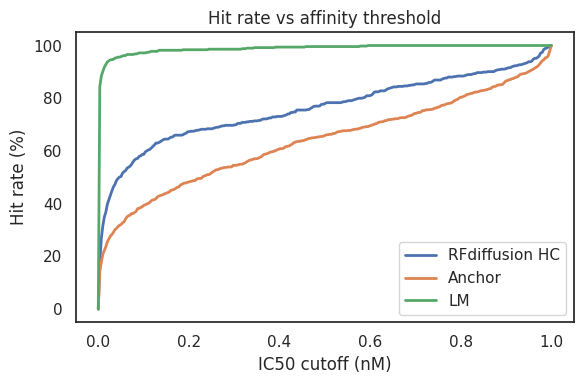

In [ ]:
#### Q3 ─ How sensitive is the anchor paradox to threshold? (hit-rate curves)

thr = np.linspace(0,1,300)
rates = {m:[] for m in sets.keys()}
for t in thr:
    h = df[(df['pLDDT'] >= 0.8) | df['pLDDT'].isna()].ESMCBA_logIC50 <= t # np.log10(t)
    for m, sub in sets.items():
        rates[m].append(h.loc[sub.index].mean()*100)
plt.figure(figsize=(6,4))
for m,r in rates.items():
    plt.plot(thr,r,lw=2,label=m)
plt.xlabel("IC50 cutoff (nM)"); plt.ylabel("Hit rate (%)")
plt.title("Hit rate vs affinity threshold"); plt.legend(); plt.tight_layout(); plt.show()


/tmp/ipykernel_1214438/2454542722.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Method', y='ESMCBA_logIC50', inner='quartile',


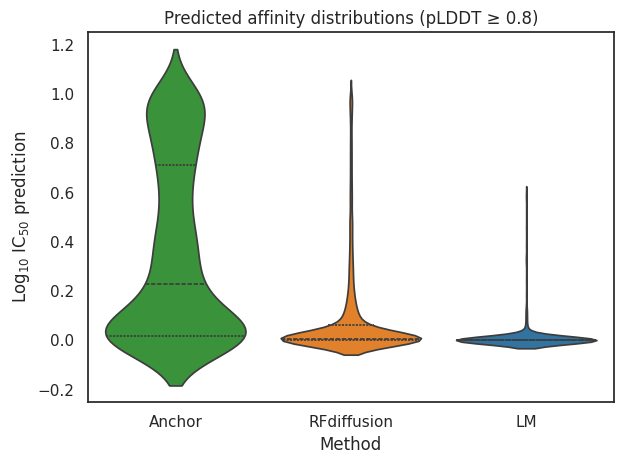

In [ ]:

sns.violinplot(data=df, x='Method', y='ESMCBA_logIC50', inner='quartile',
               palette=['tab:green','tab:orange','tab:blue'])
plt.ylabel('Log$_{10}$ IC$_{50}$ prediction')
plt.title('Predicted affinity distributions (pLDDT ≥ 0.8)')
plt.tight_layout()
plt.show()


In [ ]:
#### Q5 ─ Full-range performance: per-allele precision-recall curves

from sklearn.metrics import precision_recall_curve, auc
pr_dict=[]
for allele in df.HLA.unique():
    gt  = (mask_hit & (df.HLA==allele)).astype(int)
    for m,label in [(df_hc,"RFdiffusion"),(df_anchor,"Anchor"),(df_lm,"LM")]:
        idx = m.index.intersection(df.index[df.HLA==allele])
        if idx.empty: continue
        scores = -df.loc[idx,'ESMCBA_logIC50']  # lower logIC50 = higher score
        y      = gt.loc[idx]
        P,R,_  = precision_recall_curve(y, scores)
        pr_auc = auc(R,P)
        pr_dict.append((allele,label,pr_auc))
pr_auc_df = pd.DataFrame(pr_dict, columns=["HLA","Method","PR_AUC"])
display(pr_auc_df.pivot(index="HLA",columns="Method",values="PR_AUC").round(2))


/clusterfs/nilah/sergio/miniconda3/envs/ESM_cambrian/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Method  Anchor   LM  RFdiffusion
HLA                             
A0201     0.07  0.5         0.05

In [ ]:
import math
from functools import lru_cache
from collections import Counter
from scipy.spatial.distance import jensenshannon
import numpy as np
import pandas as pd

# ——— load IEDB & build train_dict as before ———
def load_iedb(alleles, n=1000):
    rows = []
    for h in alleles:
        path = f"/global/scratch/users/sergiomar10/data/IEDB_SQL/IEDB_HLA{h}_final.csv"
        seqs = pd.read_csv(path, header=None, usecols=[0,8])
        seqs = seqs[seqs[8]=='Positive-High'].iloc[:,0]
        idx = np.random.choice(len(seqs), size=min(n, len(seqs)), replace=False)
        for s in seqs.iloc[idx]:
            rows.append((s, h))
    return pd.DataFrame(rows, columns=["sequence","HLA"])

iedb = load_iedb(df.HLA.unique())

train_dict = {
    h: sub.groupby(sub.sequence.str.len())['sequence'].apply(list).to_dict()
    for h, sub in iedb.groupby('HLA')
}

# ——— build background frequencies & vectors for entropy/JSD ———
all_train = "".join(iedb.sequence)
bg_counts = Counter(all_train)
total_bg = sum(bg_counts.values())
bg_freq = {aa: cnt/total_bg for aa, cnt in bg_counts.items()}

# Specify amino-acid order
AAs   = list("ACDEFGHIKLMNPQRSTVWY")
# background probability vector in that order
bg_vec = np.array([bg_freq.get(aa, 1e-8) for aa in AAs])

# ——— similarity / entropy / distance functions ———

def max_identity(seq, ref_dict):
    L, best = len(seq), 0
    for l, refs in ref_dict.items():
        for r in refs:
            sc = sum(a==b for a,b in zip(seq, r)) / max(L, l)
            best = max(best, sc)
            if best == 1: return 1
    return best

def min_norm_identity(seq, ref_dict):
    L, best = len(seq), 0
    for l, refs in ref_dict.items():
        for r in refs:
            sc = sum(a==b for a,b in zip(seq, r)) / min(L, l) if min(L, l)>0 else 0
            best = max(best, sc)
            if best == 1: return 1
    return best

def shannon_entropy(seq, _=None):
    counts = Counter(seq)
    L = len(seq)
    return -sum((c/L) * math.log2(c/L) for c in counts.values())

def cross_entropy(seq, _=None, eps=1e-8):
    return -sum(math.log2(bg_freq.get(a, eps)) for a in seq) / len(seq)

def comp_vec(seq):
    cnt = Counter(seq)
    L   = len(seq)
    return np.array([cnt.get(aa,0)/L for aa in AAs])

def js_distance(seq, _=None):
    p = comp_vec(seq)
    # scipy’s jensenshannon returns the sqrt(JS divergence)
    return jensenshannon(p, bg_vec, base=2)

def euclid_dist(seq, _=None):
    p = comp_vec(seq)
    # Euclidean distance to the background AA-frequency vector
    return np.linalg.norm(p - bg_vec)

# ——— apply all metrics in one loop ———
sim_funcs = {
    'max_id':      max_identity,
    'min_id':      min_norm_identity,
    'H_comp':      shannon_entropy,
    'H_cross':     cross_entropy,
    'JS_dist':     js_distance,
    'Euclid_dist': euclid_dist,
}

for col, func in sim_funcs.items():
    df[col] = [
        func(seq, train_dict.get(h, {}))
        for seq, h in zip(df.sequence, df.HLA)
    ]

df.head()


sequence    HLA  pLDDT  ESMCBA_logIC50  Anchor     LM  Method  \
0    RAKLLGAEEK  A0201    NaN        0.000137    True  False  Anchor   
8   GRAKLLGAEEK  A0201    NaN        0.000187    True  False  Anchor   
9     FGLAKLLGA  A0201    NaN        0.090378    True  False  Anchor   
10  GLAKLLGAEEK  A0201    NaN        0.005909    True  False  Anchor   
11   LAKLLGAEEK  A0201    NaN        0.000209    True  False  Anchor   

      max_id    min_id    H_comp   H_cross   JS_dist  Euclid_dist  
0   0.300000  0.333333  2.521928  4.411014  0.694243     0.355010  
8   0.363636  0.444444  2.550341  4.429237  0.695747     0.352703  
9   0.555556  0.555556  2.197160  3.697746  0.647521     0.345181  
10  0.454545  0.555556  2.299896  4.129398  0.693443     0.356132  
11  0.400000  0.444444  2.246439  4.081191  0.692120     0.363789

/tmp/ipykernel_1214438/4162427687.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['id_bin']=pd.cut(df_plot[col_test],bins,labels=[f"{b:.2f}-{b+0.05:.1f}" for b in bins[:-1]],


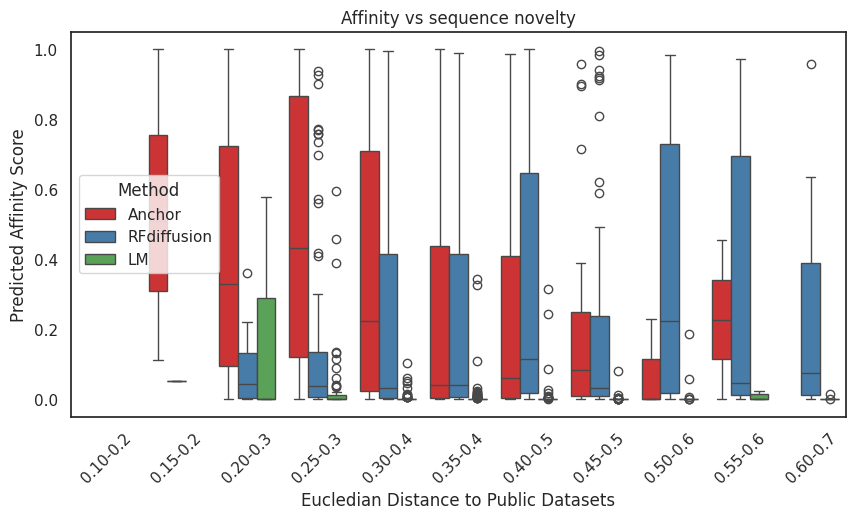

In [ ]:
#### Q7 ─ Does predicted affinity correlate with novelty? (violin plot)
df_plot = df[(df['pLDDT'] >= 0.8) | df['pLDDT'].isna()] #[df['ESMCBA_logIC50'] < 4]
col_test = 'Euclid_dist'

# bins=np.arange(np.min(df_plot[col_test]), df_plot[col_test].max() ,0.1)

bins=np.arange(0.1,0.7,0.05)

df_plot['id_bin']=pd.cut(df_plot[col_test],bins,labels=[f"{b:.2f}-{b+0.05:.1f}" for b in bins[:-1]],
                    include_lowest=True)
plt.figure(figsize=(10,5))
sns.boxplot(data=df_plot[df_plot.id_bin.notna()], x="id_bin", y="ESMCBA_logIC50",
               hue="Method", palette="Set1")
plt.xlabel(f"Eucledian Distance to Public Datasets"); plt.ylabel("Predicted Affinity Score"); 
plt.title("Affinity vs sequence novelty"); plt.xticks(rotation=45); 

# Save figure
output_path = os.path.join(output_dir, f'SIMILARITY.pdf')
plt.savefig(output_path, bbox_inches='tight')
plt.show()

Spearman correlations:
  Anchor          ρ = -0.31, p = 2.63e-23
  RFdiffusion     ρ = 0.12, p = 4.29e-03
  LM              ρ = -0.34, p = 9.16e-15

Linear regression (IC50 vs distance):
  Anchor          slope = -1.53, p = 1.33e-15, R² = 0.06
  RFdiffusion     slope = 0.47, p = 4.38e-03, R² = 0.02
  LM              slope = -0.10, p = 4.39e-04, R² = 0.02


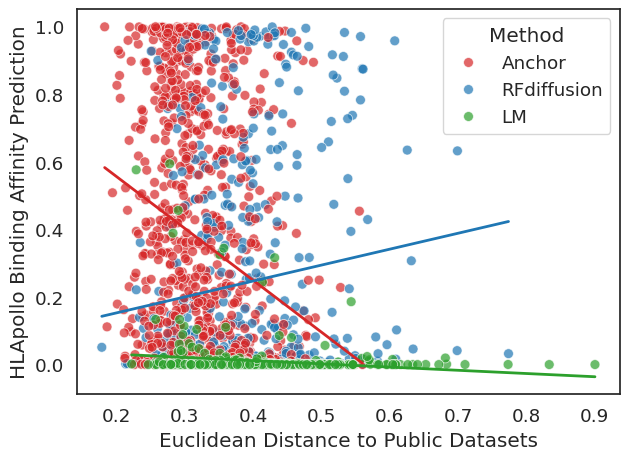

In [ ]:
from scipy.stats import spearmanr, linregress

# Assume df_plot is your DataFrame with columns:
# ['Euclid_dist','ESMCBA_logIC50','Method']

methods = df_plot['Method'].unique()

# 1) Compute per‐method Spearman correlation
print("Spearman correlations:")
for m in methods:
    sub = df_plot[df_plot['Method'] == m]
    rho, p = spearmanr(sub['Euclid_dist'], sub['ESMCBA_logIC50'])
    print(f"  {m:15s} ρ = {rho:.2f}, p = {p:.2e}")

# 2) Compute per‐method linear regression (slope, intercept, p‐value)
print("\nLinear regression (IC50 vs distance):")
for m in methods:
    sub = df_plot[df_plot['Method'] == m]
    slope, intercept, r_value, p_value, stderr = linregress(
        sub['Euclid_dist'], sub['ESMCBA_logIC50']
    )
    print(f"  {m:15s} slope = {slope:.2f}, p = {p_value:.2e}, R² = {r_value**2:.2f}")

# 3) Scatter plot + regression lines
sns.set(style="white", font_scale=1.2)
plt.figure(figsize=(7,5))
palette = {"Anchor":"tab:red", "RFdiffusion":"tab:blue", "LM":"tab:green"}

# scatter
ax = sns.scatterplot(
    data=df_plot,
    x='Euclid_dist',
    y='ESMCBA_logIC50',
    hue='Method',
    palette=palette,
    alpha=0.7,
    s=50
)

# add trend lines
for m in methods:
    sub = df_plot[df_plot['Method'] == m]
    slope, intercept, _, _, _ = linregress(
        sub['Euclid_dist'], sub['ESMCBA_logIC50']
    )
    xs = np.linspace(sub['Euclid_dist'].min(), sub['Euclid_dist'].max(), 100)
    ys = intercept + slope * xs
    ax.plot(xs, ys, color=palette[m], lw=2)

ax.set_xlabel('Euclidean Distance to Public Datasets')
ax.set_ylabel('HLApollo Binding Affinity Prediction')
# ax.set_title('Affinity vs. Sequence Novelty with Trend Lines')
ax.legend(title='Method')

output_path = os.path.join(output_dir, f'EUCLEADIAN_DISTANCE_SCATTER.pdf')
plt.savefig(output_path, bbox_inches='tight')
plt.show()


In [ ]:
# #Save as fasta
# df['sequence'] #save these as fasta in the format >peptide1 sequence

# def save_fasta(df, filename):
#     with open(filename, 'w') as f:
#         for seq in df['sequence']:
#             f.write(f">{seq}\n{seq}\n")
#     print(f"Saved {len(df)} sequences to {filename}")
# # Example usage
# save_fasta(df, '/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/figures/rfdiffusion_sequences.fasta')

In [ ]:
# col_test = 'max_id'
# bins = np.arange(df_plot[col_test].min(),
#                  df_plot[col_test].max()+1,
#                  0.1)
# labels = [f"{b:.1f}–{b+0.1:.1f}" for b in bins[:-1]]
# df_plot['id_bin'] = pd.cut(df_plot[col_test],
#                            bins=bins,
#                            labels=labels,
#                            include_lowest=True)

# # 2) group & aggregate
# summary = (
#     df_plot
#     .dropna(subset=['id_bin', 'ESMCBA_logIC50'])
#     .groupby(['id_bin','Method'])['ESMCBA_logIC50']
#     .agg(
#         N      = 'count',
#         # Median = 'median',
#         Q1     = lambda x: x.quantile(0.25),
#         Q3     = lambda x: x.quantile(0.75),
#     )
#     .reset_index()
# )

# # 3) emit LaTeX
# latex = summary.to_latex(index=False,
#     column_format="llrrrr",
#     float_format="%.2f",
#     caption="Affinity vs Novelty by ID-Bin and Method",
#     label="tab:affinity_novelty"
# )
# print(latex)


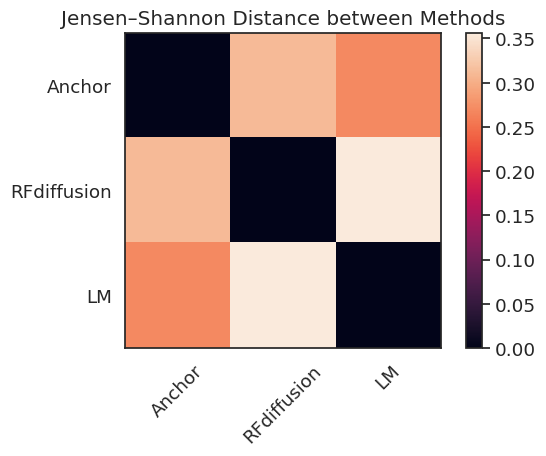

               Anchor  RFdiffusion        LM
Anchor       0.000000     0.311700  0.269469
RFdiffusion  0.311700     0.000000  0.356726
LM           0.269469     0.356726  0.000000


In [ ]:
# 1) Define your 20 standard AAs and a helper to get a composition vector
AAs = list("ACDEFGHIKLMNPQRSTVWY")
def comp_vec(seq):
    cnt = Counter(seq)
    L   = len(seq)
    return np.array([cnt.get(aa, 0)/L for aa in AAs])

# 2) Aggregate sequences per method
methods = df['Method'].unique()
comp = {}
for m in methods:
    allseq = "".join(df.loc[df['Method'] == m, 'sequence'])
    comp[m] = comp_vec(allseq)

# 3) Compute the 3×3 Jensen–Shannon distance matrix
dist = pd.DataFrame(index=methods, columns=methods, dtype=float)
for i in methods:
    for j in methods:
        dist.loc[i, j] = jensenshannon(comp[i], comp[j], base=2)

# 4) Visualize as a heatmap
fig, ax = plt.subplots()
im = ax.imshow(dist.values)
ax.set_xticks(np.arange(len(methods)))
ax.set_yticks(np.arange(len(methods)))
ax.set_xticklabels(methods, rotation=45)
ax.set_yticklabels(methods)
ax.set_title("Jensen–Shannon Distance between Methods")
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

# (Optional) inspect the numeric matrix:
print(dist)

In [ ]:
[:[[[[[qwoijdqowijdqowijdc]]]]]]

sequence  prediction  UMAP_1_x  UMAP_2_x dataset  Unnamed: 0_x  \
0      SDLSLGPEA    5.025822  5.581143  4.680666   A0201           0.0   
1      SSLSLGPEA    5.024071  5.430584  4.642436   A0201           1.0   
2      SSLSLGPHA    4.819687  5.158812  4.731397   A0201           2.0   
3      SSLSLGFHA    4.007002  4.627771  4.790965   A0201           5.0   
4      SDLSLGFEA    4.278176  5.205836  4.650356   A0201           7.0   
...          ...         ...       ...       ...     ...           ...   
24062  YVNPDAGAA    3.865093 -0.627353  7.133856   B1501          22.0   
24063  YIEPDAGAA    3.911218 -0.663394  7.097418   B1501          24.0   
24064  YIDPTAGAA    3.980139 -0.656323  7.104160   B1501          26.0   
24065  YINPDAGAG    3.283753  2.079319  4.742339   B1501          27.0   
24066  EIEPDAGAG    3.753712 -0.591897  7.124247   B1501          30.0   

       design_x   n_x    mpnn_x   plddt_x  ...  Peptide_y  BA_Rank  \
0           0.0   0.0  1.062539  0.286750  ...        NaN      NaN   
1           0.0   1.0  1.055919  0.286837  ...        NaN      NaN   
2           0.0   2.0  1.129460  0.288033  ...        NaN      NaN   
3           0.0   5.0  1.069345  0.406397  ...        NaN      NaN   
4           0.0   7.0  1.103003  0.309058  ...        NaN      NaN   
...         ...   ...       ...       ...  ...        ...      ...   
24062       0.0  22.0  1.436621  0.340256  ...  YVNPDAGAA   8.7360   
24063       0.0  24.0  1.393617  0.268060  ...  YIEPDAGAA  25.1504   
24064       0.0  26.0  1.422590  0.291395  ...  YIDPTAGAA  21.9946   
24065       0.0  27.0  1.399309  0.276736  ...  YINPDAGAG   9.8865   
24066       0.0  30.0  1.387558  0.300298  ...  EIEPDAGAG  70.6240   

       RANDOM_SAMPLED PERMUTATION_TEST plddt_x_bins  prediction_label  \
0                 NaN              NaN      0.2-0.3                 0   
1                 NaN              NaN      0.2-0.3                 0   
2                 NaN              NaN      0.2-0.3                 0   
3                 NaN              NaN      0.4-0.5                 0   
4                 NaN              NaN      0.3-0.4                 0   
...               ...              ...          ...               ...   
24062           False            False      0.3-0.4                 0   
24063           False            False      0.2-0.3                 0   
24064           False            False      0.2-0.3                 0   
24065           False            False      0.2-0.3                 0   
24066           False            False      0.3-0.4                 0   

       mhc_log_y_label  BA_Rank_label    peptide  mhc_pred_0  
0                    0              0  SDLSLGPEA  -38.507525  
1                    0              0  SSLSLGPEA  -37.665597  
2                    0              0  SSLSLGPHA  -39.210855  
3                    0              0  SSLSLGFHA  -37.809690  
4                    0              0  SDLSLGFEA  -37.442533  
...                ...            ...        ...         ...  
24062                0              1  YVNPDAGAA  -38.649507  
24063                0              1  YIEPDAGAA  -43.580001  
24064                0              1  YIDPTAGAA  -41.281255  
24065                0              1  YINPDAGAG  -42.826305  
24066                0              0  EIEPDAGAG  -42.379874  

[24067 rows x 70 columns]

In [ ]:
df_hc[df_hc['Method'] == 'RFdiffusion']

sequence    HLA     pLDDT  ESMCBA_logIC50  Anchor     LM       Method
12245   SGMQPLPPF  A0201  0.839943        0.002055   False  False  RFdiffusion
12295    MVPPPVPV  A0201  0.825287        0.957927   False  False  RFdiffusion
12298    MVPPAIAT  A0201  0.820010        0.361633   False  False  RFdiffusion
12299    SVPPPIPI  A0201  0.874456        0.782998   False  False  RFdiffusion
12301    MVPPPIPV  A0201  0.848315        0.970681   False  False  RFdiffusion
...           ...    ...       ...             ...     ...    ...          ...
33641   SISGTLHLV  A0201  0.870779        0.900187   False  False  RFdiffusion
33815   DLALPVPLG  A0201  0.813336        0.018213   False  False  RFdiffusion
33945  SMEGEVVASA  A0201  0.885001        0.142149   False  False  RFdiffusion
33954  MELGPVVATV  A0201  0.803687        0.063439   False  False  RFdiffusion
33980  APLSEPAPIH  A0201  0.828385        0.004443   False  False  RFdiffusion

[535 rows x 7 columns]

/clusterfs/nilah/sergio/miniconda3/envs/ESM_cambrian/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/clusterfs/nilah/sergio/miniconda3/envs/ESM_cambrian/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/clusterfs/nilah/sergio/miniconda3/envs/ESM_cambrian/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/clusterfs/nilah/sergio/miniconda3/envs/ESM_cambrian/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.

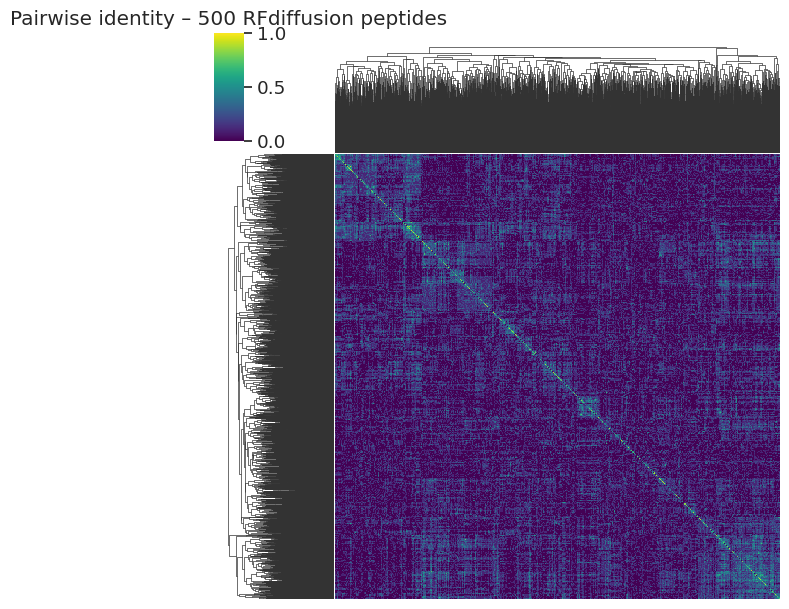

In [ ]:
#### Q8 ─ How diverse are designs among themselves? (pairwise-identity heatmap)

from itertools import combinations
def pairwise_identity(seq_list):
    n=len(seq_list)
    pid=np.zeros((n,n))
    for (i,s1),(j,s2) in combinations(enumerate(seq_list),2):
        pid[i,j]=pid[j,i]=sum(a==b for a,b in zip(s1,s2))/len(s1)
    return pid
    
sample = predictions.sequence[:10000].tolist()
pid    = pairwise_identity(sample)
sns.clustermap(pid, cmap="viridis", figsize=(6,6), xticklabels=False, yticklabels=False)
plt.title("Pairwise identity – 500 RFdiffusion peptides"); plt.show()

/clusterfs/nilah/sergio/miniconda3/envs/ESM_cambrian/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/clusterfs/nilah/sergio/miniconda3/envs/ESM_cambrian/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/clusterfs/nilah/sergio/miniconda3/envs/ESM_cambrian/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/clusterfs/nilah/sergio/miniconda3/envs/ESM_cambrian/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.

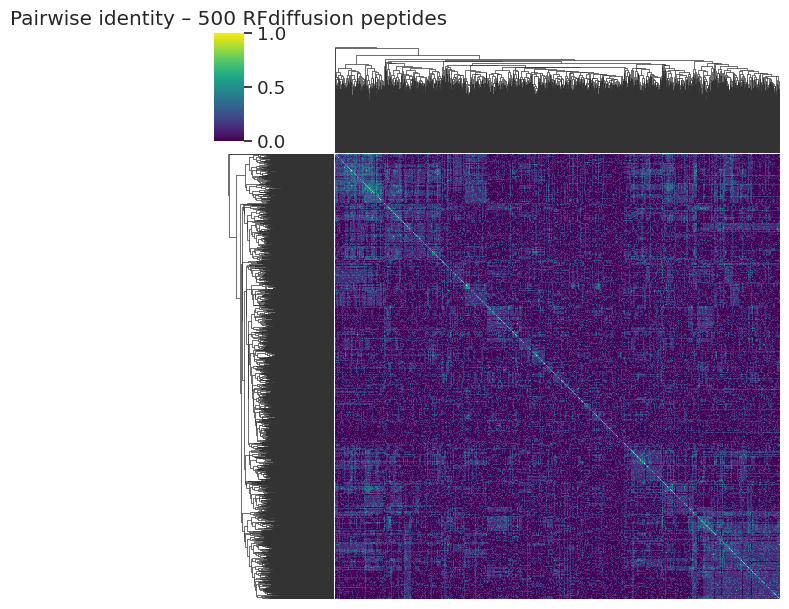

In [ ]:
#### Q8 ─ How diverse are designs among themselves? (pairwise-identity heatmap)

from itertools import combinations
def pairwise_identity(seq_list):
    n=len(seq_list)
    pid=np.zeros((n,n))
    for (i,s1),(j,s2) in combinations(enumerate(seq_list),2):
        pid[i,j]=pid[j,i]=sum(a==b for a,b in zip(s1,s2))/len(s1)
    return pid
    
sample = predictions.sequence.tolist()
pid    = pairwise_identity(sample)
sns.clustermap(pid, cmap="viridis", figsize=(6,6), xticklabels=False, yticklabels=False)
plt.title("Pairwise identity – 500 RFdiffusion peptides"); plt.show()

In [ ]:
#save pid as np 
np.save('/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/jupyter_notebooks/rdfiffusion/pid.npy', pid)

In [ ]:
#### Q9 ─ Do designs explore motifs outside IEDB? (Jensen–Shannon divergence)

from scipy.spatial.distance import jensenshannon
def pwm(df_seqs, L):
    mat=np.zeros((L,20))
    for s in df_seqs: 
        if len(s)!=L: continue
        for i,a in enumerate(s): 
            if a in AA: mat[i,AA.index(a)]+=1
    return (mat+1e-9)/mat.sum(1,keepdims=True)
jsd=[]
for h, grp in df_hc.groupby('HLA'):
    L=grp.sequence.str.len().mode()[0]
    rf_pwm = pwm(grp.sequence, L)
    ref_pwm = pwm(iedb.loc[iedb.HLA==h, 'sequence'], L)
    js = jensenshannon(rf_pwm.flatten(), ref_pwm.flatten())
    jsd.append((h,js))
jsd_df = pd.DataFrame(jsd, columns=["HLA","JSD_logo"])
print(jsd_df.sort_values("JSD_logo").head())


     HLA  JSD_logo
0  A0201  0.480972


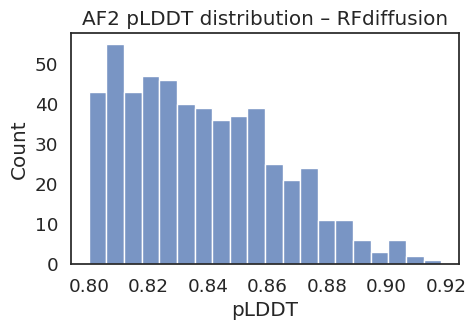

In [ ]:
#### Q10 ─ Structural sanity: pLDDT & (placeholder) Rosetta ΔΔG

plt.figure(figsize=(5,3))
sns.histplot(df_hc.pLDDT, bins=20, kde=False)
plt.title("AF2 pLDDT distribution – RFdiffusion"); plt.xlabel("pLDDT"); plt.show()

# OPTIONAL: Rosetta Interface ΔΔG – run externally, then load scores.csv
# scores = pd.read_csv("rosetta_dg.csv")  # columns: sequence, dG
# sns.histplot(scores.dG, bins=20); plt.title("Rosetta ΔΔG"); plt.show()


In [ ]:
# #### Q11 ─ Save exact package versions for the camera-ready zip

# import subprocess, sys
# pkgs = subprocess.check_output([sys.executable, "-m", "pip", "freeze"]).decode().splitlines()
# with open("requirements_exact.txt","w") as fh:
#     fh.write("\n".join(sorted(pkgs)))
# print("✓ wrote requirements_exact.txt")


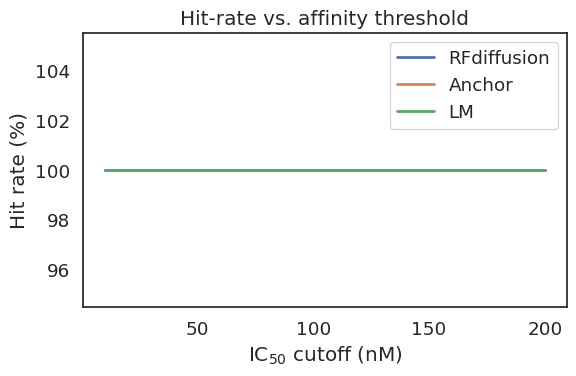

In [ ]:
import matplotlib.pyplot as plt

thresholds = np.linspace(10,200,20)  # nM
results = {'RFdiffusion':[], 'Anchor':[], 'LM':[]}

for thr in thresholds:
    mask = df['ESMCBA_logIC50'] <= np.log10(thr)
    for name, subset in [
        ('RFdiffusion', df_hc),
        ('Anchor',      df_anchor),
        ('LM',          df_lm)
    ]:
        rate = mask.loc[subset.index].mean() * 100
        results[name].append(rate)

plt.figure(figsize=(6,4))
for name, rates in results.items():
    plt.plot(thresholds, rates, label=name, lw=2)
plt.xlabel('IC$_{50}$ cutoff (nM)')
plt.ylabel('Hit rate (%)')
plt.title('Hit‐rate vs. affinity threshold')
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_1214438/43391739.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_plot, x='Method', y='ESMCBA_logIC50', inner='quartile',


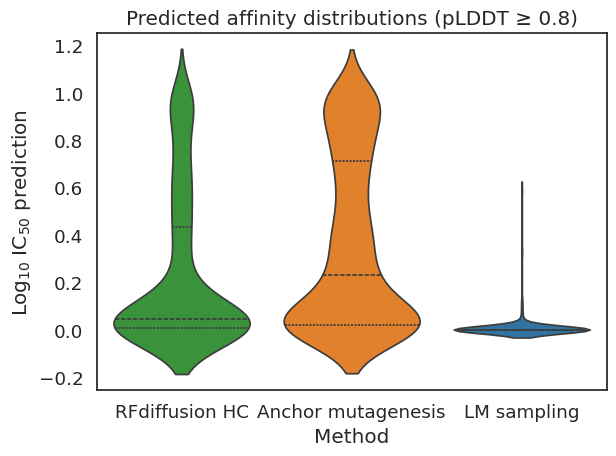

In [ ]:
import seaborn as sns
df_plot = pd.concat([
    df_hc.assign(Method='RFdiffusion HC'),
    df_anchor.assign(Method='Anchor mutagenesis'),
    df_lm.assign(Method='LM sampling')
])
sns.violinplot(data=df_plot, x='Method', y='ESMCBA_logIC50', inner='quartile',
               palette=['tab:green','tab:orange','tab:blue'])
plt.ylabel('Log$_{10}$ IC$_{50}$ prediction')
plt.title('Predicted affinity distributions (pLDDT ≥ 0.8)')
plt.tight_layout()
plt.show()


In [ ]:
num_sequences_test = 500

training_data = pd.DataFrame()

for formatted_HLA in ['A0201', 'B1501', 'B5701']:
    
    train_fasta = f"/global/scratch/users/sergiomar10/data/IEDB_SQL/IEDB_HLA{formatted_HLA}_final.csv"

    train_fasta = pd.read_csv(train_fasta, header=None)
    train_fasta.columns = ['sequence', 'ref_ID', 'submissionID', 'Epitope_ID', 'protein_origin', 
                        'ID_SOURCE', 'SOURCE_ORGANISM', 'IC50_nM', 'DESCRIPTION_BINDING', 'Year_submission']
    train_fasta['HLA'] = formatted_HLA
    train_fasta = train_fasta[['sequence','HLA']].head(num_sequences_test)
    training_data = pd.concat([training_data, train_fasta])

###############################################################################
# Compute max-identity of every generated peptide against the IEDB training
# peptides of the same HLA.  Adds a `max_identity` column to your dataframe.
###############################################################################
from Bio import pairwise2
import numpy as np
import pandas as pd

# ---------------------------------------------------------------------------
# 1.  Build a lookup:  {HLA → {length → list_of_training_peptides}}
# ---------------------------------------------------------------------------
training_by_hla = {}

for hla, grp in training_data.groupby('HLA'):
    length_dict = {}
    for s in grp['sequence']:
        length_dict.setdefault(len(s), []).append(s)
    training_by_hla[hla] = length_dict

# ---------------------------------------------------------------------------
# 2.  Helper to compute identity between two peptides
#     (fast exact-length check + fallback Smith–Waterman)
# ---------------------------------------------------------------------------
def max_identity_to_training(seq, ref_len_dict):
    L = len(seq)
    best = 0.0

    # -------- exact same length (fast path) ------------------
    if L in ref_len_dict:
        for ref in ref_len_dict[L]:
            best = max(best, sum(a == b for a, b in zip(seq, ref)) / L)
            if best == 1.0:
                return 1.0

    # -------- unequal length (rare) --------------------------
    # Local alignment, match=1, mismatch=0, no gaps rewarded
    for length, ref_list in ref_len_dict.items():
        if length == L:     # already done above
            continue
        for ref in ref_list:
            aln = pairwise2.align.localms(seq, ref, 1, 0, -10, -10,
                                          one_alignment_only=True)
            if aln:
                score = aln[0][2]
                best = max(best, score / max(L, length))
                if best == 1.0:
                    return 1.0
    return best

# ---------------------------------------------------------------------------
# 3.  Apply to your full dataset (df) and add a column
# ---------------------------------------------------------------------------
def attach_max_identity(df):
    max_id_list = []
    for seq, hla in zip(df['sequence'], df['HLA']):
        ref_dict = training_by_hla.get(hla, {})
        max_id_list.append(max_identity_to_training(seq, ref_dict))
    df = df.copy()
    df['max_identity'] = max_id_list
    return df

# Example usage:
df_with_id = attach_max_identity(ESCMBA_predictions[(ESCMBA_predictions['RANDOM_SAMPLED'] == True) |
                    (ESCMBA_predictions['PERMUTATION_TEST'] == True) | 
                    (ESCMBA_predictions['plddt'] > 0.6 ) 
                    ])  # or your merged df
print(df_with_id[['sequence','HLA','max_identity']].head())


# Use your df_viz DataFrame; ensure it has ['max_identity','prediction_x','Method']
df_viz = df_viz.copy()

# Create identity bins from 0.2 to 0.8 in steps of 0.1
bins = np.arange(0.2, 0.9, 0.1)
labels = [f"{bins[i]:.1f}-{bins[i+1]:.1f}" for i in range(len(bins)-1)]
df_viz['identity_bin'] = pd.cut(
    df_viz['max_identity'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# Plot violin plots per bin, colored by method
plt.figure(figsize=(12, 6))
sns.set(style="white", font_scale=1.2)

ax = sns.violinplot(
    data=df_viz[df_viz['identity_bin'].notna()],
    x='identity_bin',
    y='prediction_x',
    hue='Method',
    # split=True,
    # inner='quartile',
    palette='Set1'
)

ax.set_xlabel('Maximum Identity Bin')
ax.set_ylabel('ESMCBA log₁₀ IC₅₀ Prediction')
ax.set_title('Affinity Distributions Across Sequence Novelty Bins')
plt.xticks(rotation=45)
ax.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



      sequence    HLA  max_identity
0   RAKLLGAEEK  A0201      0.400000
1   RAKLLGAEEK  A0201      0.400000
2  GRAKLLGAEEK  A0201      0.363636
3    FGLAKLLGA  A0201      0.400000
4  GLAKLLGAEEK  A0201      0.363636


NameError: name 'df_viz' is not defined

In [ ]:
hit_mask = (
    (df_with_id['prediction_x'] <= np.log10(500))   # IC50 ≤ 500 nM
    # (df_with_id['plddt'] >= 0.8)                        # AF2 pLDDT ≥ 0.8
)


In [ ]:
def label_method(row):
    if row['RANDOM_SAMPLED']:
        return 'LM sampling'
    elif row['PERMUTATION_TEST']:
        return 'Anchor mutagenesis'
    elif row['plddt'] > 0.8:
        return 'RFdiffusion high-confidence'
    else:
        return 'RFdiffusion low-confidence'

df_viz['Method'] = df_viz.apply(label_method, axis=1)
# Use your df_viz DataFrame; ensure it has ['max_identity','prediction_x','Method']
df_viz = df_viz.copy()

# Create identity bins from 0.2 to 0.8 in steps of 0.1
bins = np.arange(0.2, 0.9, 0.1)
labels = [f"{bins[i]:.1f}-{bins[i+1]:.1f}" for i in range(len(bins)-1)]
df_viz['identity_bin'] = pd.cut(
    df_viz['max_identity'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# Plot violin plots per bin, colored by method
plt.figure(figsize=(12, 6))
sns.set(style="white", font_scale=1.2)

ax = sns.boxplot(
    data=df_viz[df_viz['identity_bin'].notna()],
    x='identity_bin',
    y='mhc_log_y',
    hue='Method',
    # split=True,
    # inner='quartile',
    palette='Set1'
)

ax.set_xlabel('Maximum Identity Bin')
ax.set_ylabel('MHC Flurry Predicted log₁₀ IC₅₀ Prediction')
# ax.set_title('Predicted Affinity Distributions Across Sequence Novelty Bins')
plt.xticks(rotation=45)
ax.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

NameError: name 'df_viz' is not defined

In [ ]:

# Use your df_viz DataFrame; ensure it has ['max_identity','prediction_x','Method']
df_viz = df_viz.copy()

# Create identity bins from 0.2 to 0.8 in steps of 0.1
bins = np.arange(0.2, 0.9, 0.1)
labels = [f"{bins[i]:.1f}-{bins[i+1]:.1f}" for i in range(len(bins)-1)]
df_viz['identity_bin'] = pd.cut(
    df_viz['max_identity'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# Plot violin plots per bin, colored by method
plt.figure(figsize=(12, 6))
sns.set(style="white", font_scale=1.2)

ax = sns.boxplot(
    data=df_viz[df_viz['identity_bin'].notna()],
    x='identity_bin',
    y='prediction_x',
    hue='Method',
    # split=True,
    # inner='quartile',
    palette='Set1'
)

ax.set_xlabel('Maximum Identity Bin')
ax.set_ylabel('ESMCBA log₁₀ IC₅₀ Prediction')
ax.set_title('Affinity Distributions Across Sequence Novelty Bins')
plt.xticks(rotation=45)
ax.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


NameError: name 'df_viz' is not defined

In [ ]:
# define anchor positions (0-indexed)
ANCHORS = {9: (1,8), 10: (1,9)}  # for 9-mers and 10-mers

def max_nonanchor_identity(seq, ref_len_dict):
    L = len(seq)
    anchors = ANCHORS.get(L, ())
    best = 0.0

    # for each reference of same length
    for ref in ref_len_dict.get(L, []):
        # count identical non-anchor positions
        matches = sum(
            (a == b) 
            for i,(a,b) in enumerate(zip(seq,ref))
            if i not in anchors
        )
        best = max(best, matches / (L - len(anchors)))
        if best == 1.0:
            return 1.0
    return best

# attach to your df
mapping = training_by_hla  # from earlier snippet
df_with_id['nonanchor_id'] = [
    max_nonanchor_identity(seq, mapping.get(hla, {}))
    for seq,hla in zip(df_with_id['sequence'], df_with_id['HLA'])
]

df_with_id['Method'] = df_with_id.apply(label_method, axis=1)
# Use your df_viz DataFrame; ensure it has ['max_identity','prediction_x','Method']
df_viz = df_with_id.copy()



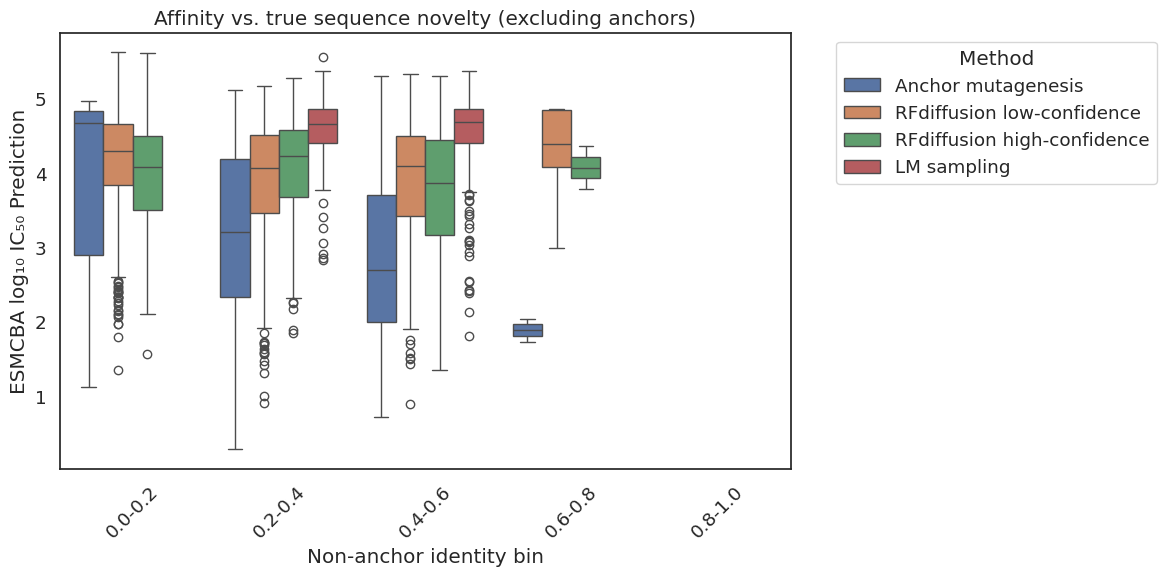

In [ ]:
import numpy as np

# new bins on the non-anchor axis
bins = np.linspace(0,1,6)      # e.g. [0–0.2,0.2–0.4,…,0.8–1.0]
labels = [f"{bins[i]:.1f}-{bins[i+1]:.1f}" for i in range(len(bins)-1)]
df_viz['nonanchor_bin'] = pd.cut(df_viz['nonanchor_id'],
                                     bins=bins, labels=labels,
                                     include_lowest=True)

# violin of predicted affinity by nonanchor_bin & Method (reuse palette)
plt.figure(figsize=(12,6))
sns.boxplot(
    data=df_viz[df_viz['nonanchor_bin'].notna()],
    x='nonanchor_bin',
    y='prediction_x',
    hue='Method',
    # split=True,
    # inner='quartile',
    # palette=palette
)
plt.xlabel('Non-anchor identity bin')
plt.ylabel('ESMCBA log₁₀ IC₅₀ Prediction')
plt.title('Affinity vs. true sequence novelty (excluding anchors)')
plt.xticks(rotation=45)
plt.legend(title='Method', bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.show()


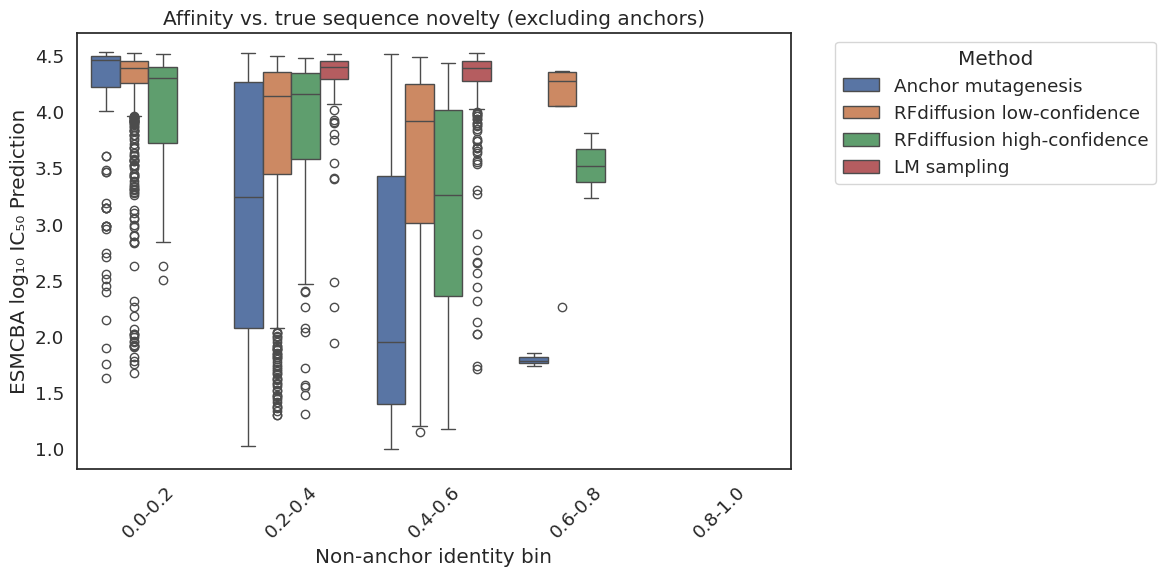

In [ ]:
import numpy as np

# new bins on the non-anchor axis
bins = np.linspace(0,1,6)      # e.g. [0–0.2,0.2–0.4,…,0.8–1.0]
labels = [f"{bins[i]:.1f}-{bins[i+1]:.1f}" for i in range(len(bins)-1)]
df_viz['nonanchor_bin'] = pd.cut(df_viz['nonanchor_id'],
                                     bins=bins, labels=labels,
                                     include_lowest=True)

# violin of predicted affinity by nonanchor_bin & Method (reuse palette)
plt.figure(figsize=(12,6))
sns.boxplot(
    data=df_viz[df_viz['nonanchor_bin'].notna()],
    x='nonanchor_bin',
    y='mhc_log_y',
    hue='Method',
    # split=True,
    # inner='quartile',
    # palette=palette
)
plt.xlabel('Non-anchor identity bin')
plt.ylabel('ESMCBA log₁₀ IC₅₀ Prediction')
plt.title('Affinity vs. true sequence novelty (excluding anchors)')
plt.xticks(rotation=45)
plt.legend(title='Method', bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.show()


In [ ]:
summary = []
for method, flag in [
    ('RFdiffusion', None),                # all peptides
    ('Anchor',       'PERMUTATION_TEST'),
    ('LM',           'RANDOM_SAMPLED'),
]:
    subset = df_with_id if flag is None else df_with_id[df_with_id[flag]]
    total   = len(subset)
    hits    = hit_mask.loc[subset.index].sum()
    median_id = subset['max_identity'].median()
    diversity = 1 - median_id            # 0 → identical, 1 → maximally novel
    summary.append((method, total, hits, hits/total*100, diversity))

plot_df = pd.DataFrame(summary,
                       columns=['Method','N_peptides','Hits',
                                'Hit_rate_%','Diversity'])
print(plot_df)


        Method  N_peptides  Hits  Hit_rate_%  Diversity
0  RFdiffusion        4229   692   16.363206   0.600000
1       Anchor        1162   471   40.533563   0.600000
2           LM         514     7    1.361868   0.666667


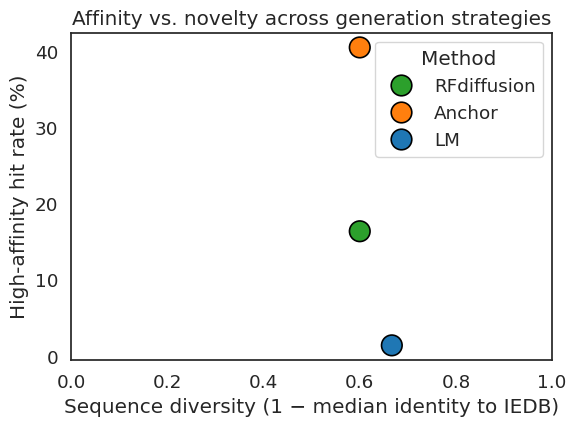

In [ ]:
import seaborn as sns, matplotlib.pyplot as plt

sns.set(style="white", font_scale=1.2)
plt.figure(figsize=(6,4.5))

palette = {'RFdiffusion':'tab:green',
           'Anchor':'tab:orange',
           'LM':'tab:blue'}

ax = sns.scatterplot(data=plot_df, x='Diversity', y='Hit_rate_%',
                     hue='Method', palette=palette, s=220, edgecolor='black')

# for _, row in plot_df.iterrows():
#     ax.text(row.Diversity+0.004, row.Hit_rate_%+0.3,
#             f"{row.Hit_rate_%:.1f}%", ha='left', va='bottom', fontsize=10)

ax.set_xlabel('Sequence diversity (1 − median identity to IEDB)')
ax.set_ylabel('High-affinity hit rate (%)')
ax.set_xlim(0, 1)
ax.set_title('Affinity vs. novelty across generation strategies')

output_dir = '/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/figures/'
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, f'DIVERSITY_VS_HIGHAFFINITY.pdf')
plt.savefig(output_path, bbox_inches='tight')

plt.tight_layout()
plt.show()


In [ ]:
hit_df.to_latex('hit_rates.tex',
                index=False,
                float_format='%.1f',
                caption="High-affinity hit rates for each method (IC$_{50}\le50$\,nM, AF2 pLDDT$\ge0.8$).",
                label="tab:hit_rates",
                column_format='lrrr')


In [ ]:
from scipy.stats import fisher_exact

# 2×2 table RF vs Anchor
table = [
    [ hit_df.loc[0,'Hits'], hit_df.loc[0,'N_peptides']-hit_df.loc[0,'Hits'] ],
    [ hit_df.loc[1,'Hits'], hit_df.loc[1,'N_peptides']-hit_df.loc[1,'Hits'] ]
]
oddsratio, pvalue = fisher_exact(table)
print(f"RF vs Anchor: p={pvalue:.2e}")


KeyError: 'N_peptides'

In [ ]:
import numpy as np, pandas as pd
from scipy.spatial.distance import jensenshannon
from Bio import pairwise2

# ------------------------------------------------------------
# helper functions (unchanged)
# ------------------------------------------------------------
def build_pwm(seqs, length=9):
    aa = "ACDEFGHIKLMNPQRSTVWY"
    pwm = np.zeros((20, length))
    for s in seqs:
        if len(s) != length:
            continue
        for i, res in enumerate(s):
            if res not in aa:
                break
            pwm[aa.index(res), i] += 1
    pwm = pwm / pwm.sum(axis=0, keepdims=True)
    return pwm

def max_identity(query, ref_set):
    if len(query) in {len(r) for r in ref_set}:      # fast exact-length check
        return max(sum(q == r for q, r in zip(query, ref)) / len(query)
                   for ref in ref_set)
    best = 0
    for ref in ref_set:
        aln = pairwise2.align.localms(query, ref, 1, 0, -10, -10,
                                      one_alignment_only=True)
        if aln:
            best = max(best, aln[0][2] / max(len(query), len(ref)))
    return best

# ------------------------------------------------------------
# parameters
# ------------------------------------------------------------
L            = 9          # peptide length for PWM
N_PER_GROUP  = 1000       # sample cap per allele
RNG          = np.random.default_rng(0)

# ------------------------------------------------------------
# split sets (must have 'sequence' and 'HLA' columns)
# ------------------------------------------------------------
train_df = training_data[['sequence', 'HLA']].dropna()
rfdiff   = final_df[final_df['measured'].isna()][['sequence', 'HLA']]

allele_results   = []
identity_records = []     # optional: for histogram later

for allele, gen_sub in rfdiff.groupby('HLA'):
    # -----------------------------------------------------------------
    # sample up to N_PER_GROUP sequences per set (without replacement)
    # -----------------------------------------------------------------
    gen_sample = gen_sub.sample(min(len(gen_sub), N_PER_GROUP),
                                random_state=RNG.integers(1e9))['sequence']
    
    train_sub  = train_df[train_df['HLA'] == allele]
    if train_sub.empty:
        continue                                    # no training peptides for this allele
    train_sample = train_sub.sample(min(len(train_sub), N_PER_GROUP),
                                    random_state=RNG.integers(1e9))['sequence']

    # -----------------------------------------------------------------
    # PWM + Jensen–Shannon divergence
    # -----------------------------------------------------------------
    pwm_train = build_pwm(train_sample, length=L)
    pwm_gen   = build_pwm(gen_sample,  length=L)
    eps       = 1e-9
    jsd_bits  = jensenshannon(pwm_train.flatten() + eps,
                              pwm_gen.flatten()   + eps,
                              base=2)

    # -----------------------------------------------------------------
    # optional: max-identity distribution for this allele
    # -----------------------------------------------------------------
    ref_set = set(train_sample)        # exact lengths only (all 9-mers)
    ids     = [max_identity(p, ref_set) for p in gen_sample]
    identity_records.extend([(allele, v) for v in ids])

    allele_results.append({
        'HLA': allele,
        'n_train': len(train_sample),
        'n_gen':   len(gen_sample),
        'JSD_bits': jsd_bits
    })

# ------------------------------------------------------------
# tidy outputs
# ------------------------------------------------------------
allele_jsd = pd.DataFrame(allele_results).sort_values('JSD_bits')
print(allele_jsd.head())

id_df = pd.DataFrame(identity_records, columns=['HLA', 'max_identity'])
# id_df.to_csv('identity_per_allele_sampled.csv', index=False)  # if you need it

# global stats you might quote
median_jsd = allele_jsd['JSD_bits'].median()
print(f"Median per-allele JSD (sample ≤{N_PER_GROUP} per set): {median_jsd:.3f} bits")


     HLA  n_train  n_gen  JSD_bits
0  A0201      500   1000  0.432275
Median per-allele JSD (sample ≤1000 per set): 0.432 bits


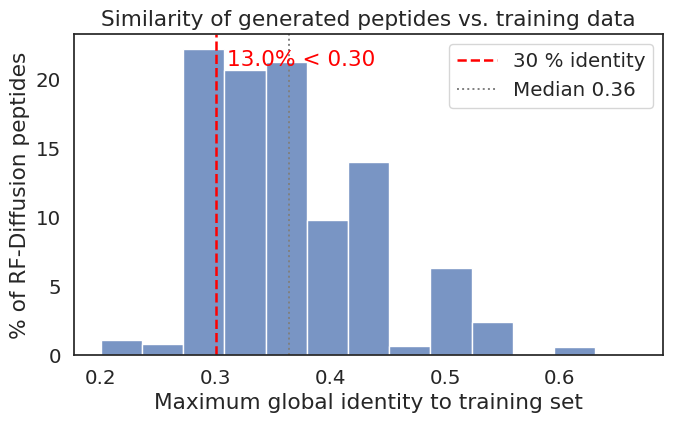

In [ ]:

sns.set(style="white", font_scale=1.3)

fig, ax = plt.subplots(figsize=(7, 4.5))

# histogram with percent y-axis
sns.histplot(id_df['max_identity'],
             bins=13,
             stat='percent',
             edgecolor=None,
             ax=ax)

# 30 % similarity threshold
ax.axvline(0.30, ls='--', lw=1.8, color='red',
           label='30 % identity')

pct = (id_df['max_identity'] < 0.30).mean() * 100
ax.text(0.31, ax.get_ylim()[1]*0.9,
        f'{pct:0.1f}% < 0.30', color='red')
         
med = id_df['max_identity'].median()
ax.axvline(med, color='grey', ls=':', lw=1.4, label=f'Median {med:0.2f}')


ax.set_xlabel('Maximum global identity to training set')
ax.set_ylabel('% of RF-Diffusion peptides')
ax.set_title('Similarity of generated peptides vs. training data')
ax.legend(frameon=True)



plt.tight_layout()
output_dir = '/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/figures/'
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, f'SIMILARITY.pdf')
plt.savefig(output_path, bbox_inches='tight')


# plt.tight_layout()
plt.show()


In [ ]:

# ------------------------------------------------------------------
def pct_below(series, thresh=0.30):
    return 100 * (series < thresh).mean()

summary = (id_df
           .groupby('HLA')['max_identity']
           .agg(n_pep='size',
                median_id='median',
                pct_lt_0_30=pct_below)
           .reset_index()
           .sort_values('median_id'))

# ------------------------------------------------------------------
# 2.  Export LaTeX (booktabs + siunitx)
# ------------------------------------------------------------------
latex_table = summary.to_latex(index=False,
                               float_format="%.2f",
                               column_format="l S[table-format=4.0] S[table-format=1.2] S[table-format=2.1]",
                               header=["Allele",
                                       "Peptides",
                                       "Median\nidentity",
                                       "%\n< 0.30"],
                               caption=("Per-allele similarity of RF Diffusion peptides "
                                        "to training set (9-mers, n ≤ 2 000 sampled each)."),
                               label="tab:identity_per_allele",
                               longtable=False,
                               escape=False,
                               bold_rows=False)

print(latex_table)


\begin{table}
\caption{Per-allele similarity of RF Diffusion peptides to training set (9-mers, n ≤ 2 000 sampled each).}
\label{tab:identity_per_allele}
\begin{tabular}{l S[table-format=4.0] S[table-format=1.2] S[table-format=2.1]}
\toprule
Allele & Peptides & Median
identity & %
< 0.30 \\
\midrule
A0201 & 1000 & 0.36 & 13.00 \\
\bottomrule
\end{tabular}
\end{table}



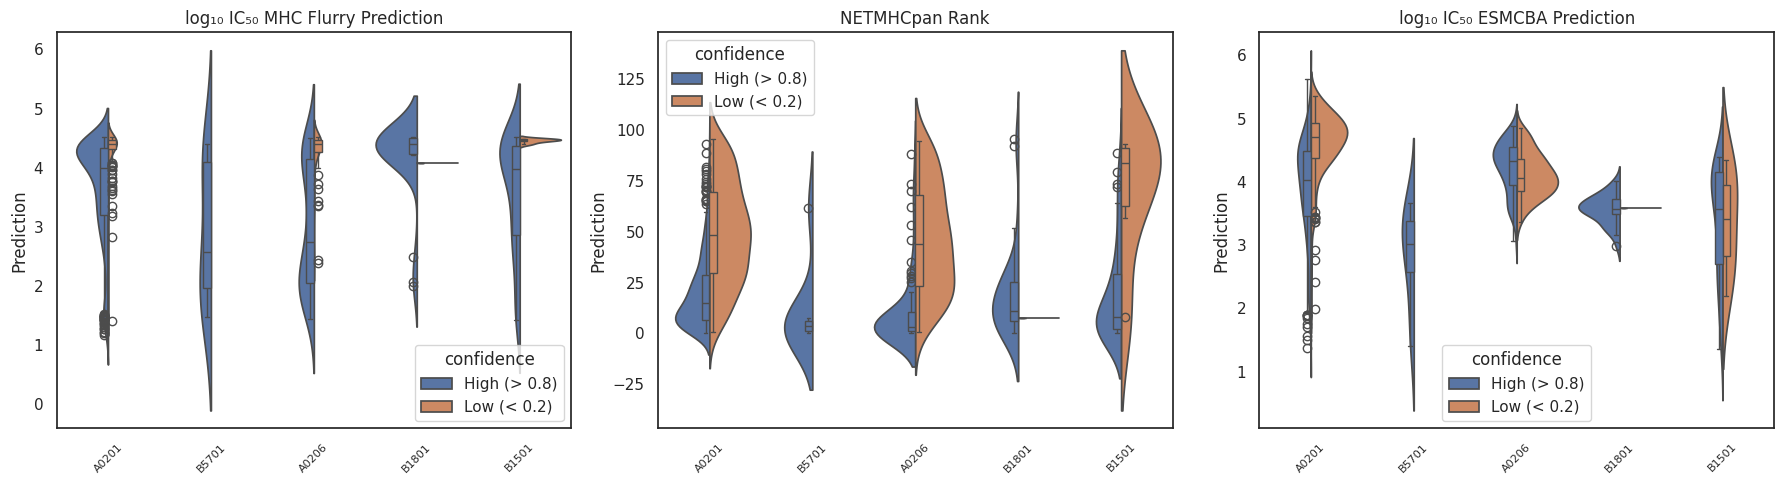

In [ ]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt

# ----------------------------------------
# 0.  final_df must already exist
# ----------------------------------------
# e.g.:
# final_df = pd.read_pickle("ALL_MERGED_UMAP_predictions.pkl")

metrics = ['mhc_log_y', 'BA_Rank', 'prediction_x']
pretty_name = {
    'mhc_log_y':    'log₁₀ IC₅₀ MHC Flurry Prediction',
    'BA_Rank':      'NETMHCpan Rank',
    'prediction_x': 'log₁₀ IC₅₀ ESMCBA Prediction'
}

# ----------------------------------------
# 1.  build plotting table — *only* rows <0.2 or >0.8
# ----------------------------------------
df_plot = (
    final_df
      .loc[:, metrics + ['plddt', 'HLA']]
      .dropna(subset=metrics + ['plddt', 'HLA'])
      .query('plddt > 0.8 or plddt < 0.2')              # keep only extremes
      .assign(confidence=lambda d:
              np.where(d['plddt'] > 0.8, 'High (> 0.8)', 'Low (< 0.2)'))
)

# (optional) cap at the 10 most frequent HLAs for readability
top_hlas = df_plot['HLA'].value_counts().head(10).index
df_plot  = df_plot[df_plot['HLA'].isin(top_hlas)]

# melt to long format
df_long = df_plot.melt(id_vars=['HLA', 'confidence'],
                       value_vars=metrics,
                       var_name='metric',
                       value_name='value')

# ----------------------------------------
# 2.  violin + box plots
# ----------------------------------------
sns.set(style="white")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, metric in zip(axes, metrics):
    subset = df_long[df_long['metric'] == metric]

    sns.violinplot(data=subset,
                   x='HLA', y='value', hue='confidence',
                   split=True, inner=None, dodge=True,
                   ax=ax, legend=True)

    sns.boxplot(data=subset,
                x='HLA', y='value', hue='confidence',
                width=0.15, #, showfliers=False,
                # showcaps=True, dodge=True,
                ax=ax, legend=False)
                # boxprops={'zorder': 3}, linewidth=1)

    ax.set_title(pretty_name[metric])
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.set_xlabel('')
    ax.set_ylabel('Prediction')

# shared legend
handles, labels = axes[0].get_legend_handles_labels()
# leg = fig.legend(handles[:2], ['Low (< 0.2)', 'High (> 0.8)'],
#                  title='pLDDT Confidence', ncol=2, loc='upper center',
#                  bbox_to_anchor=(0.5, 1.08), frameon=True)
# leg.get_frame().set_facecolor('white')
# leg.get_frame().set_edgecolor('black')

# fig.suptitle('HLA-specific Score Distributions for Extreme-confidence Structures', y=1.15)
plt.tight_layout()

output_dir = '/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/figures/'
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, f'PREDICTIONS.pdf')
plt.savefig(output_path, bbox_inches='tight')

plt.show()


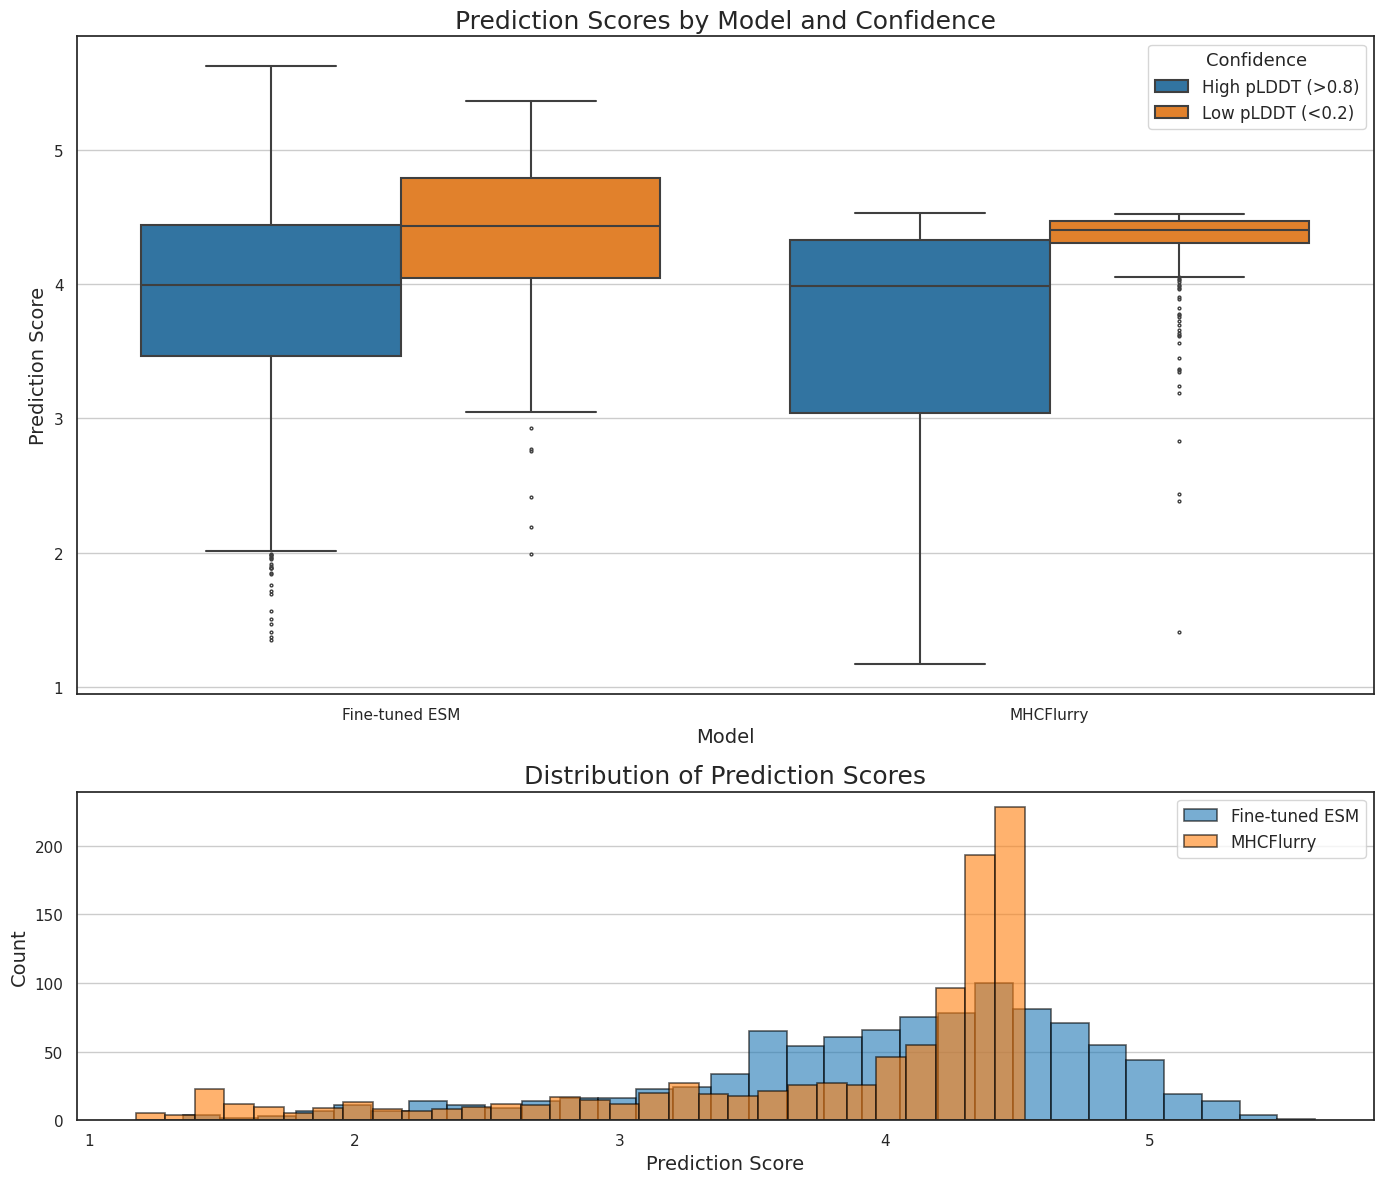

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assume final_df already exists

# Subset high and low pLDDT groups
high_confidence = final_df[final_df['plddt'] > 0.8].copy()
low_confidence = final_df[final_df['plddt'] < 0.2].copy()

# Label them
high_confidence['Confidence'] = 'High pLDDT (>0.8)'
low_confidence['Confidence'] = 'Low pLDDT (<0.2)'

# Combine
plot_df = pd.concat([high_confidence, low_confidence], ignore_index=True)

# Melt the DataFrame to long format
plot_df_melted = plot_df.melt(
    id_vars=['HLA', 'Confidence'],
    value_vars=['prediction_x', 'mhc_log_y'],
    var_name='Model',
    value_name='Score'
)

# Map model names
model_name_map = {
    'prediction_x': 'Fine-tuned ESM',
    'mhc_log_y': 'MHCFlurry'
}
plot_df_melted['Model'] = plot_df_melted['Model'].map(model_name_map)

# ---------------------------
# Plot settings
sns.set_style('white')
colors = ['#1f77b4', '#ff7f0e']  # Default seaborn blue and orange

# Set up figure with gridspec (2 rows, 1 column)
fig, (ax_box, ax_hist) = plt.subplots(2, 1, figsize=(14, 12), gridspec_kw={'height_ratios': [2, 1]})

# 1) BOX PLOT SIDE BY SIDE
sns.boxplot(
    data=plot_df_melted,
    x='Model',
    y='Score',
    hue='Confidence',
    palette=colors,
    fliersize=2,
    linewidth=1.5,
    ax=ax_box
)

# Outline boxes with black
for patch in ax_box.artists:
    patch.set_edgecolor('black')

ax_box.set_title('Prediction Scores by Model and Confidence', fontsize=18)
ax_box.set_xlabel('Model', fontsize=14)
ax_box.set_ylabel('Prediction Score', fontsize=14)
ax_box.legend(title='Confidence', fontsize=12, title_fontsize=13)
ax_box.grid(True, axis='y')

# 2) HISTOGRAM
# Separate histograms for Fine-tuned ESM and MHCFlurry
for idx, model in enumerate(['Fine-tuned ESM', 'MHCFlurry']):
    subset = plot_df_melted[plot_df_melted['Model'] == model]
    ax_hist.hist(
        subset['Score'],
        bins=30,
        alpha=0.6,
        label=model,
        color=colors[idx],
        edgecolor='black',
        linewidth=1.2
    )

ax_hist.set_title('Distribution of Prediction Scores', fontsize=18)
ax_hist.set_xlabel('Prediction Score', fontsize=14)
ax_hist.set_ylabel('Count', fontsize=14)
ax_hist.legend(fontsize=12)
ax_hist.grid(True, axis='y')

plt.tight_layout()
plt.show()


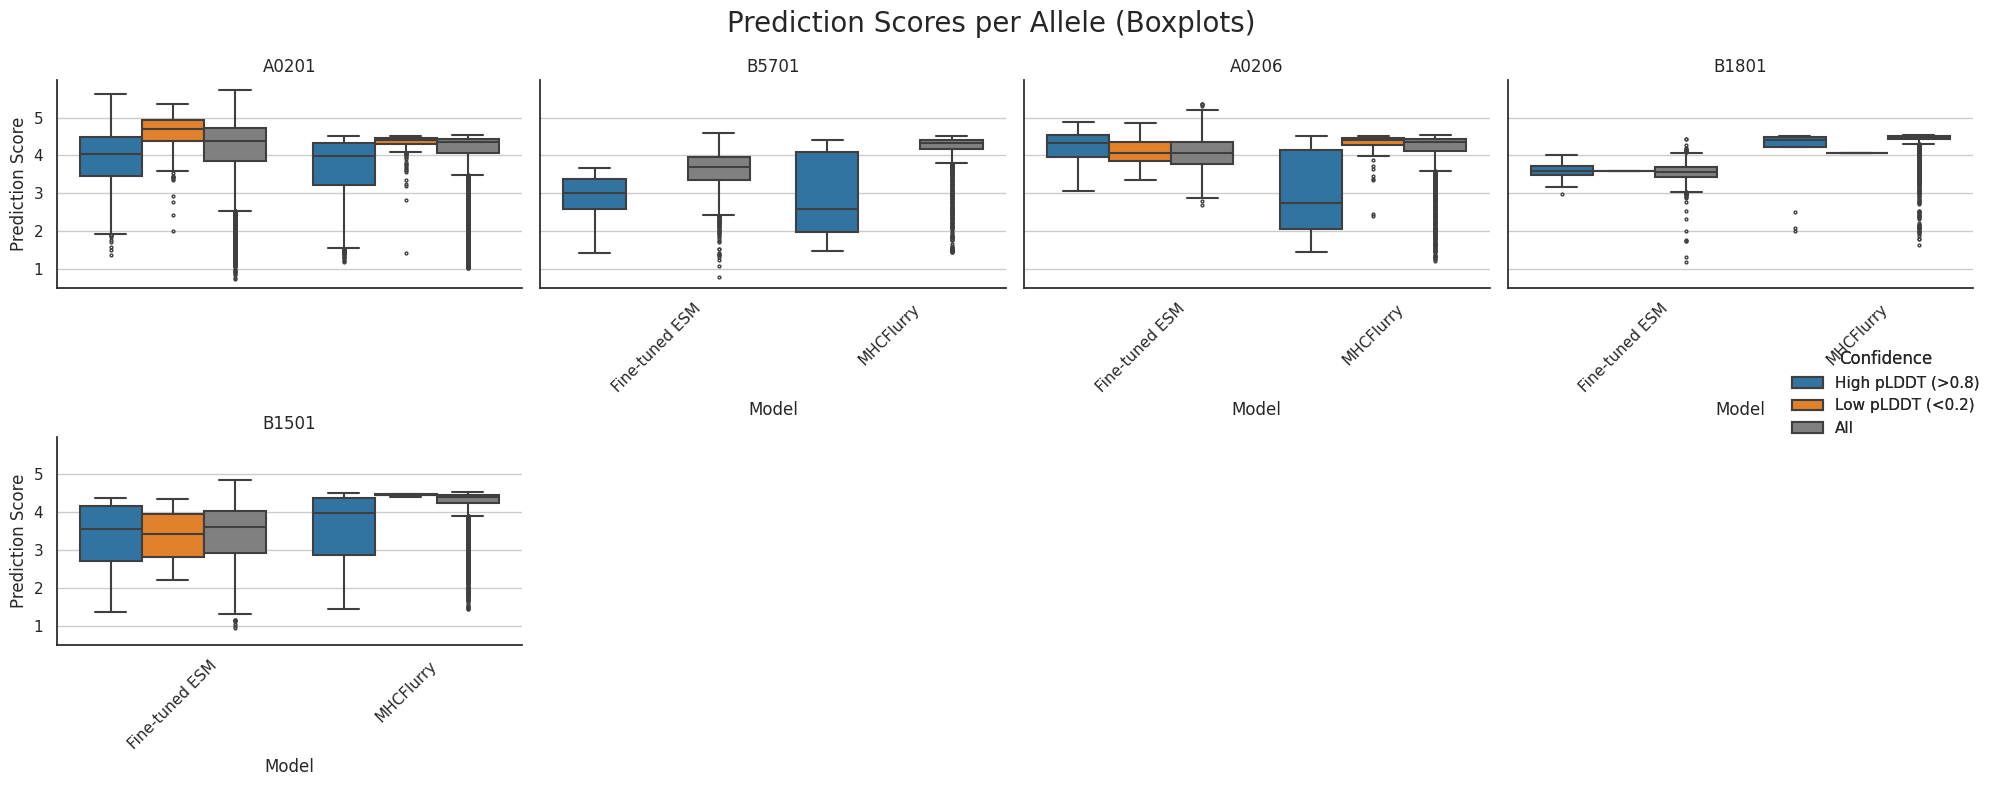

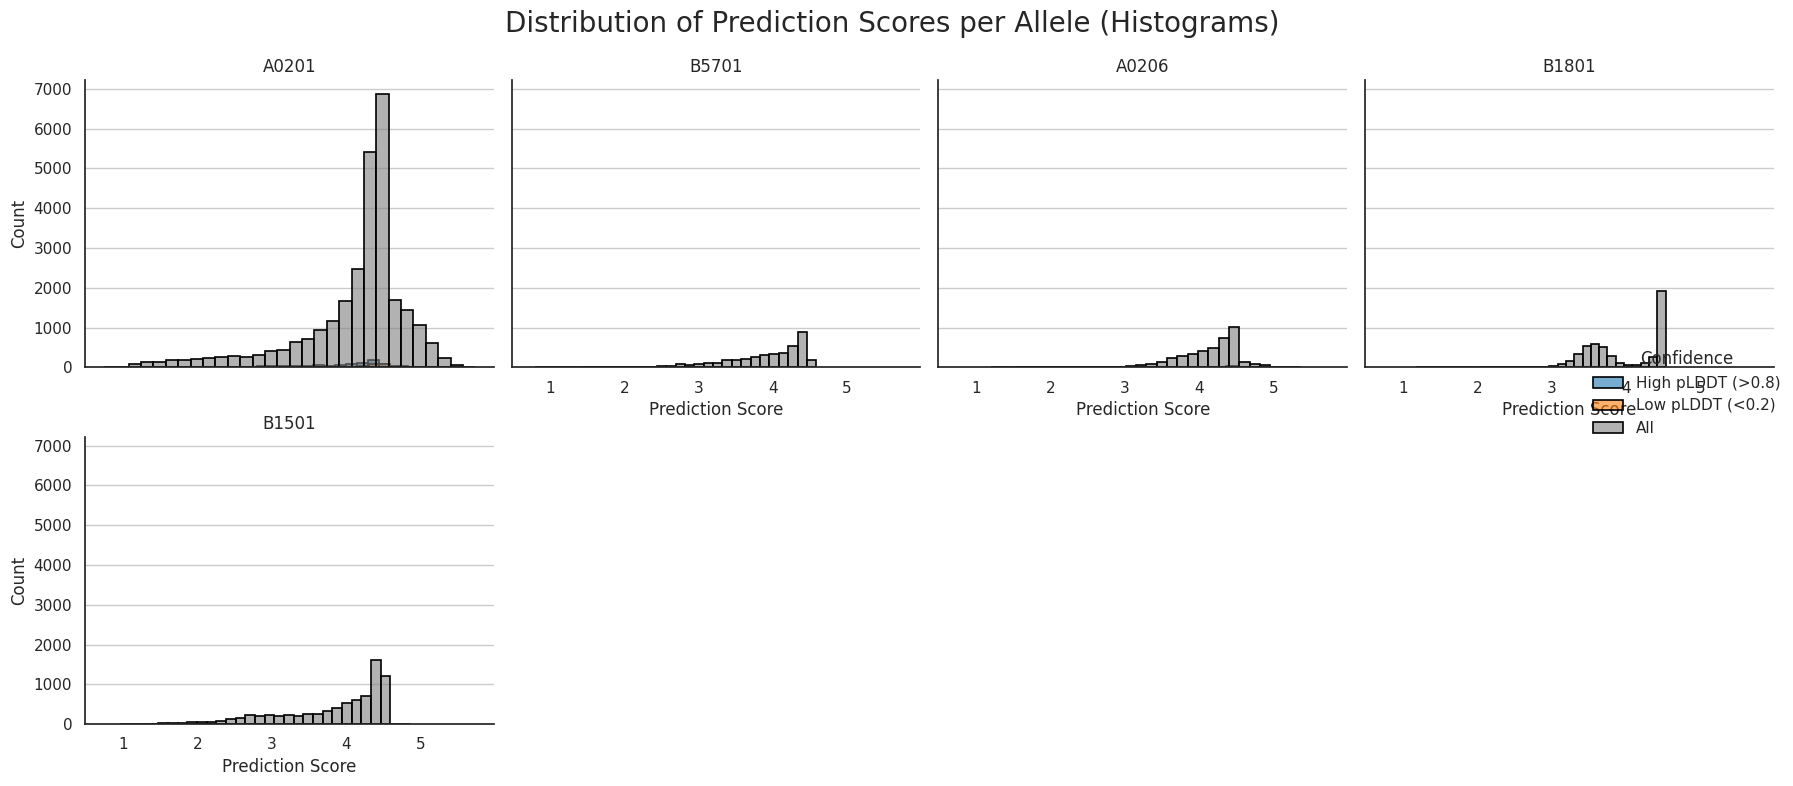

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assume final_df already exists

# Subset high, low and all
high_confidence = final_df[final_df['plddt'] > 0.8].copy()
low_confidence = final_df[final_df['plddt'] < 0.2].copy()
all_data = final_df.copy()

# Label them
high_confidence['Confidence'] = 'High pLDDT (>0.8)'
low_confidence['Confidence'] = 'Low pLDDT (<0.2)'
all_data['Confidence'] = 'All'

# Combine
plot_df = pd.concat([high_confidence, low_confidence, all_data], ignore_index=True)

# Melt the DataFrame
plot_df_melted = plot_df.melt(
    id_vars=['HLA', 'Confidence'],
    value_vars=['prediction_x', 'mhc_log_y'],
    var_name='Model',
    value_name='Score'
)

# Map model names
model_name_map = {
    'prediction_x': 'Fine-tuned ESM',
    'mhc_log_y': 'MHCFlurry'
}
plot_df_melted['Model'] = plot_df_melted['Model'].map(model_name_map)

# ---------------------------
# Plot settings
sns.set_style('white')
colors = {
    'High pLDDT (>0.8)': '#1f77b4',  # blue
    'Low pLDDT (<0.2)': '#ff7f0e',   # orange
    'All': 'gray'                    # neutral gray
}

# =============================
# First: BOX PLOT per allele
# =============================

g = sns.catplot(
    data=plot_df_melted,
    x='Model',
    y='Score',
    hue='Confidence',
    col='HLA',
    kind='box',
    palette=colors,
    col_wrap=4,
    height=4,
    aspect=1,
    fliersize=2,
    linewidth=1.5,
    dodge=True
)

# Set black outline for boxes
for ax in g.axes.flatten():
    for patch in ax.artists:
        patch.set_edgecolor('black')
        patch.set_facecolor('lightgray')

g.set_titles(col_template="{col_name}")
g.set_axis_labels("Model", "Prediction Score")
g.add_legend(title='Confidence')
for ax in g.axes.flatten():
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, axis='y')

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Prediction Scores per Allele (Boxplots)', fontsize=20)

plt.tight_layout()
plt.show()

# =============================
# Second: HISTOGRAM per allele
# =============================

# Set up again
g2 = sns.FacetGrid(
    plot_df_melted,
    col='HLA',
    hue='Confidence',
    col_wrap=4,
    height=4,
    aspect=1,
    palette=colors
)

g2.map(
    sns.histplot,
    'Score',
    bins=30,
    kde=False,
    edgecolor='black',
    linewidth=1.2,
    alpha=0.6
)

g2.add_legend(title='Confidence')
g2.set_axis_labels("Prediction Score", "Count")
g2.set_titles(col_template="{col_name}")
for ax in g2.axes.flatten():
    ax.grid(True, axis='y')

plt.subplots_adjust(top=0.9)
g2.fig.suptitle('Distribution of Prediction Scores per Allele (Histograms)', fontsize=20)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# --------------------------------------------
# 0 .  DataFrame setup
# --------------------------------------------
df = ESCMBA_predictions[ESCMBA_predictions['plddt'].notna()]   # <-- replace with your DataFrame
predictors = ['mpnn', 'plddt', 'i_ptm', 'i_pae', 'rmsd']
target = 'prediction_x'

# --------------------------------------------
# 1 .  SIMPLE (one-predictor) regressions
# --------------------------------------------
rows = []
for col in predictors:
    

    res = linregress(df[col].values, df[target].values)
    rows.append(
        {
            'predictor' : col,
            'slope'     : res.slope,
            'intercept' : res.intercept,
            'R²'        : res.rvalue**2,
            'p-value'   : res.pvalue
        }
    )

simple_summary = pd.DataFrame(rows).set_index('predictor')
print("\nOne-predictor regressions")
print(simple_summary)

# --------------------------------------------
# 2 .  MULTIPLE regression with all predictors
# --------------------------------------------
X = df[predictors].values
y = df[target].values
reg = LinearRegression().fit(X, y)

multi_summary = pd.DataFrame({
    'coef' : reg.coef_
}, index=predictors)
multi_summary.loc['intercept', 'coef'] = reg.intercept_

print("\nMultiple regression coefficients")
print(multi_summary)

print(f"\nMultiple-regression R²  : {r2_score(y, reg.predict(X)):.3f}")
print(f"Adjusted R²            : {1 - (1 - r2_score(y, reg.predict(X))) * (len(y)-1)/(len(y)-X.shape[1]-1):.3f}")


KeyError: 'plddt'

<Axes: xlabel='prediction_x', ylabel='mpnn'>

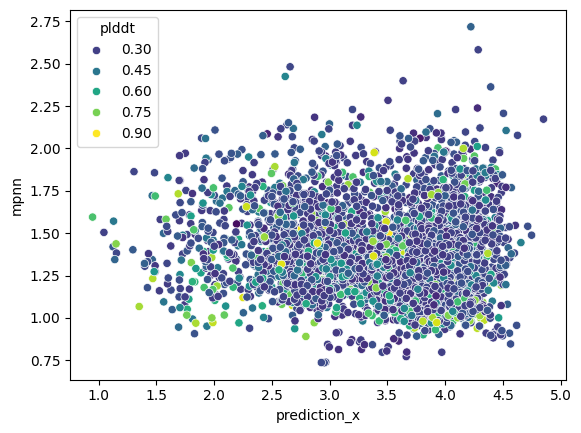

In [ ]:
sns.scatterplot(data = ESCMBA_predictions, y = 'mpnn', x ='prediction_x', hue = 'plddt', alpha =1, palette='viridis')

<Axes: xlabel='prediction_x', ylabel='plddt'>

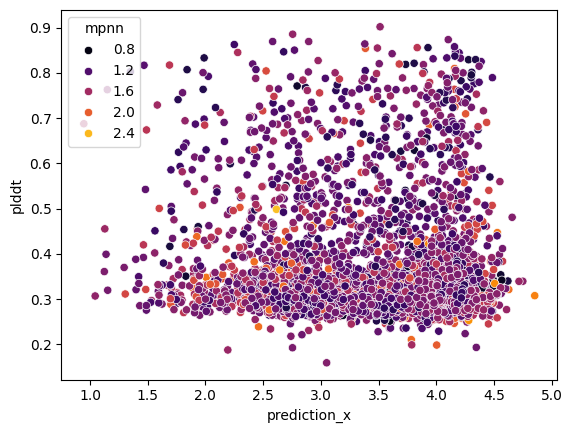

In [ ]:
sns.scatterplot(data =ESCMBA_predictions,y = 'plddt', x ='prediction_x', hue = 'mpnn', alpha =1, palette='inferno')

<Axes: xlabel='prediction_x', ylabel='plddt'>

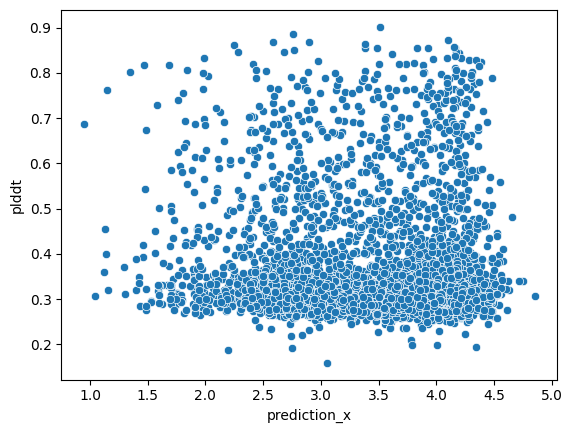

In [ ]:
sns.scatterplot(data =ESCMBA_predictions,y = 'plddt', x ='prediction_x')

Text(0.5, 1.0, 'RFdiffusion generated peptides with MHC structure fixed.')

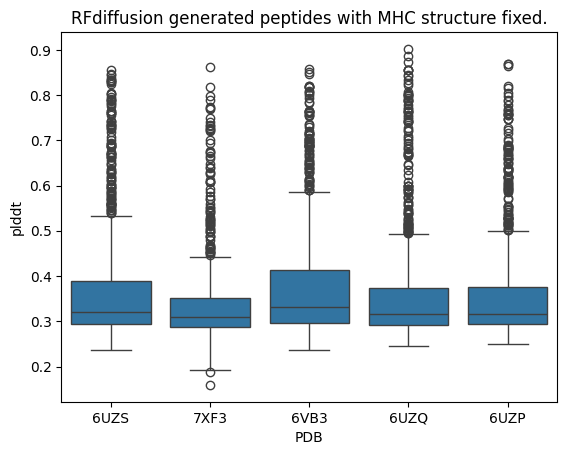

In [ ]:
sns.boxplot(data = ESCMBA_predictions, y = 'plddt', x ='PDB') #, palette='viridis')
plt.title("RFdiffusion generated peptides with MHC structure fixed.")

<Axes: xlabel='PDB', ylabel='prediction_x'>

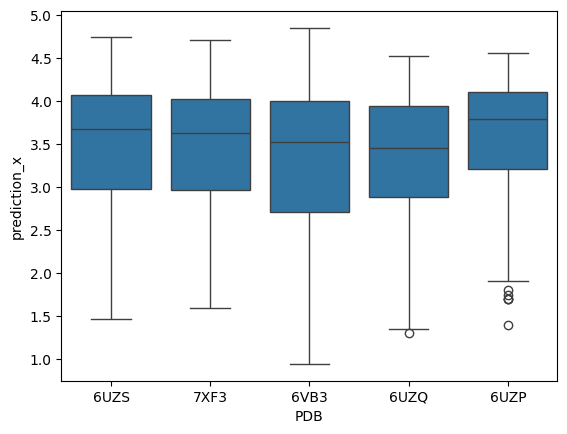

In [ ]:
sns.boxplot(data = ESCMBA_predictions, y = 'prediction_x', x ='PDB') #, palette='viridis')

<Axes: xlabel='prediction_x', ylabel='plddt'>

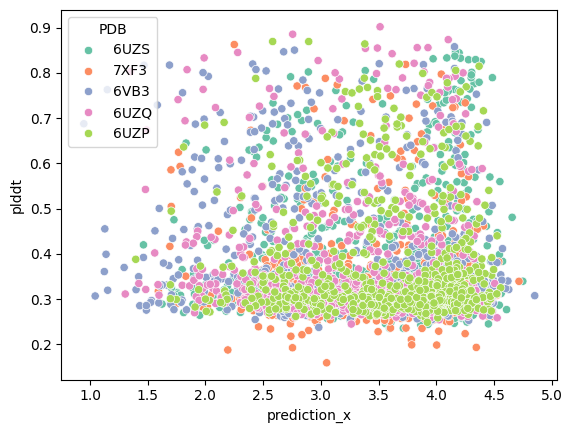

In [ ]:
sns.scatterplot(data =ESCMBA_predictions,y = 'plddt', x ='prediction_x', hue = 'PDB', palette='Set2')

<Axes: xlabel='prediction_x', ylabel='plddt'>

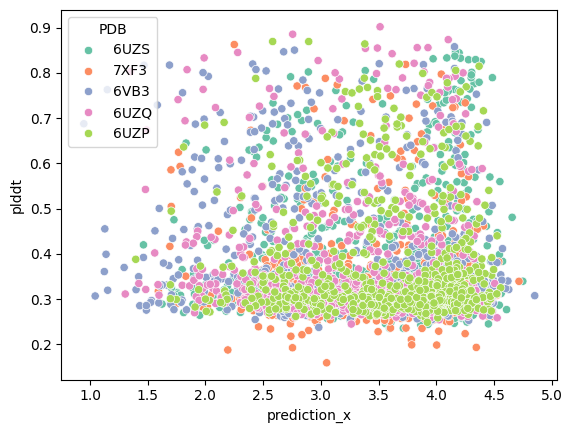

In [ ]:
sns.scatterplot(data =ESCMBA_predictions,y = 'plddt', x ='prediction_x', hue = 'PDB', palette='Set2')

In [ ]:
mhc_epitope_contacts = pd.read_csv("mhc_epitope_contacts.csv")

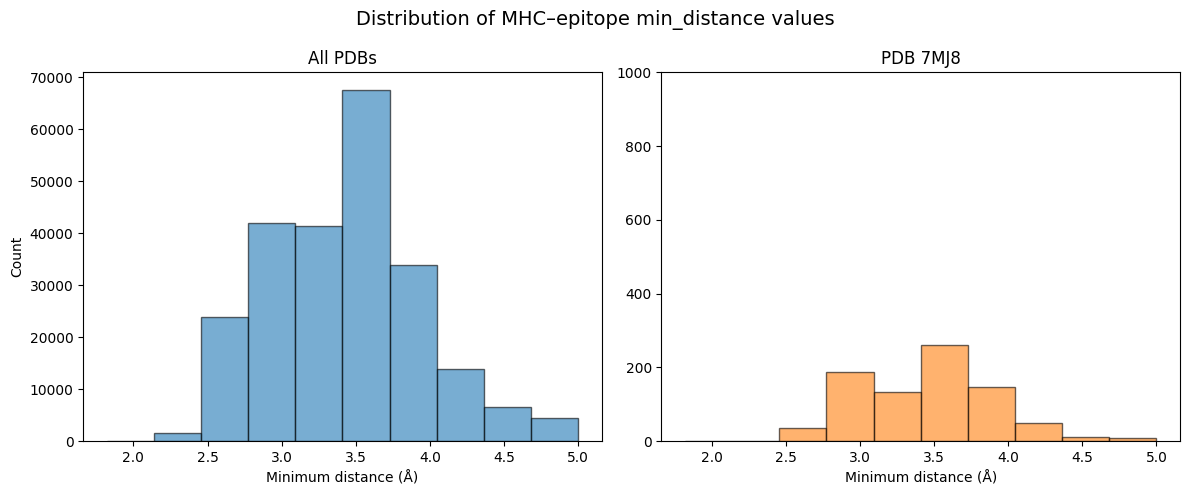

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- data ----------
all_vals    = mhc_epitope_contacts['min_distance'].dropna()
subset_vals = mhc_epitope_contacts.loc[
    mhc_epitope_contacts['pdb_id'] == '7KGQ', 'min_distance'
].dropna()

# consistent binning so the x-axes line up
bins = np.histogram_bin_edges(all_vals)

# ---------- plotting ----------
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

# panel 1 – all PDBs
axes[0].hist(all_vals,
             bins=bins,
             edgecolor='black',
             alpha=0.6)
axes[0].set_title('All PDBs')
axes[0].set_xlabel('Minimum distance (Å)')
axes[0].set_ylabel('Count')
# axes[0].set_ylim(0, 1000)      # same y-scale for easy comparison

# panel 2 – 7MJ8 only
axes[1].hist(subset_vals,
             bins=bins,
             edgecolor='black',
             alpha=0.6,
             color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])  # second default color
axes[1].set_title('PDB 7MJ8')
axes[1].set_xlabel('Minimum distance (Å)')
axes[1].set_ylim(0, 1000)

fig.suptitle('Distribution of MHC–epitope min_distance values', fontsize=14)
fig.tight_layout()
plt.show()


In [ ]:
pdb_chain_summary = pd.read_csv("pdb_chain_summary.csv").drop_duplicates()

In [ ]:
# Count chains per PDB
chain_counts = pdb_chain_summary.groupby('pdb_id').size().reset_index(name='num_chains')

# Filter to PDBs that have exactly 3 chains
three_chain_pdbs = chain_counts[chain_counts['num_chains'] == 3].sort_values(by='num_chains', ascending=False)


In [ ]:
# Filter the full chain summary to only 3-chain PDBs
filtered_summary = pdb_chain_summary[pdb_chain_summary['pdb_id'].isin(three_chain_pdbs['pdb_id'])]

In [ ]:

interactions = mhc_epitope_contacts.drop_duplicates().reset_index(drop=True)
# 1. Count how many distinct epitope residues contact each MHC residue
contact_counts = interactions.groupby(['mhc_chain', 'mhc_resnum'])['epitope_resnum'].nunique().reset_index()
contact_counts = contact_counts.rename(columns={'epitope_resnum': 'contact_count'})

# 2. Merge back into original interaction DataFrame
interactions = interactions.merge(contact_counts, on=['mhc_chain', 'mhc_resnum'], how='left')

# 3. Assign importance tier based on contact count
interactions["importance"] = interactions["contact_count"].map(
    lambda x: "core_hotspot" if x >= 4 else
              "high_contact" if x == 3 else
              "medium_contact" if x == 2 else
              "low_contact"
)


In [ ]:
job_params = []

# Only include PDBs with exactly 3 chains
chain_counts = filtered_summary.groupby('pdb_id').size()
three_chain_pdbs = chain_counts[chain_counts == 3].index.tolist()

for pdb_id in three_chain_pdbs:
    chains_df = filtered_summary[filtered_summary['pdb_id'] == pdb_id]
    chains = ",".join(chains_df['chain_id'].tolist())
    
    # Determine epitope chain: the one with smallest num_residues
    ep_chain = chains_df.loc[chains_df['num_residues'].idxmin(), 'chain_id']
    
    # Collect hotspot residues (core + high + medium)
    inter_df = interactions[
        (interactions['pdb_id'] == pdb_id) &
        (interactions['epitope_chain'] == ep_chain) &
        (interactions['importance'].isin(['core_hotspot','high_contact','medium_contact']))
    ]
    hotspots = sorted({f"{row['mhc_chain']}{row['mhc_resnum']}" for _, row in inter_df.iterrows()})

    if len(hotspots) < 5:
        inter_df = interactions[
            (interactions['pdb_id'] == pdb_id) &
            (interactions['epitope_chain'] == ep_chain) &
            (interactions['importance'].isin(['high_contact','medium_contact']))
        ]
    
    job_params.append({
        'pdb_id': pdb_id,
        'chains': chains,
        'epitope_chain': ep_chain,
        'hotspots': ",".join(hotspots)
    })

df_job_params = pd.DataFrame(job_params)

for _, row in df_job_params.iterrows():
    # get chain lengths for contigs construction
    lengths = {
        ch: filtered_summary.query(f"pdb_id=='{row.pdb_id}' & chain_id=='{ch}'").num_residues.item()
        for ch in row.chains.split(",")
    }
    # build contigs string
    parts = []
    for ch, L in lengths.items():

        if ch == row.epitope_chain:
            
            LENGTH = np.random.randint(7,13)
            L = LENGTH

            parts.append(f"0/{L}")
        else:
            parts.append(f"{ch}1-{L}/0")
    full_contigs = " ".join(parts)

In [ ]:
df_job_params['n_hospots'] = df_job_params['hotspots'].apply(lambda x: len(x.split(",")))

In [ ]:
df_job_params[df_job_params['pdb_id'] == '7KGQ']

pdb_id chains epitope_chain  \
74   7KGQ  A,B,C             C   

                                             hotspots  n_hospots  
74  A114,A116,A123,A124,A143,A146,A147,A150,A152,A...         50

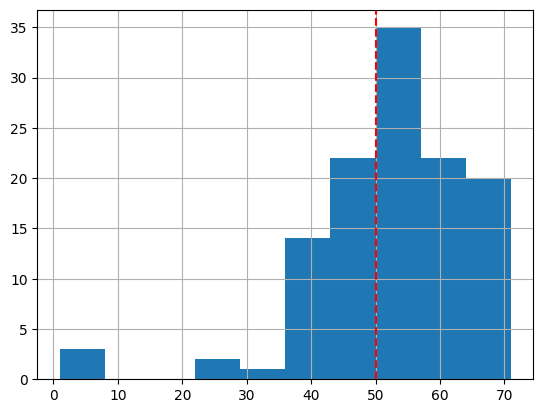

In [ ]:
df_job_params['n_hospots'].hist()
#veritcal line in the histogram
plt.axvline(x=50, color='r', linestyle='--')

In [ ]:
rfd_peptides['CREATED'] = rfd_peptides['CREATED'].str.split(" ", expand=True)[0]

<Axes: xlabel='CREATED', ylabel='plddt'>

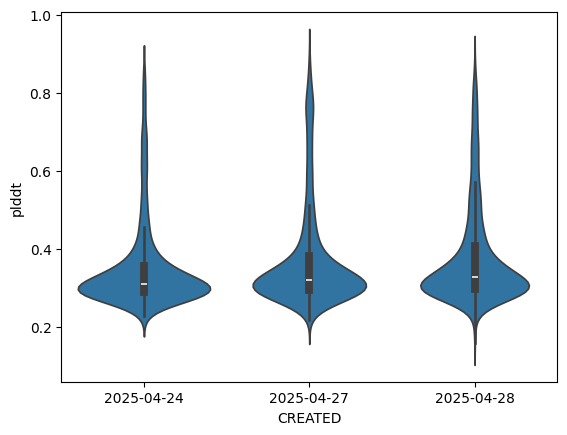

In [ ]:
sns.violinplot(data = rfd_peptides.sort_values(by='CREATED'), x = 'CREATED', y= 'plddt') #, palette='viridis')